In [ ]:
library(devtools)
install_github("r3fang/SnapATAC")

In [68]:
install.packages('ClusterProfiler')

Warning message:
"package 'ClusterProfiler' is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages"


In [ ]:
BiocManager::install('DO.db',force = TRUE)

# library

In [1]:
library(SnapATAC)
library(Matrix)
library(Seurat)
library(MAESTRO)
library(Signac)
library(qs)
library(harmony)
library(VennDiagram)
library(tidyverse)
library(hrbrthemes)
library(tm)
library(proustr)
library(SingleCellExperiment)
library(clusterProfiler)

Loading required package: Matrix

Loading required package: rhdf5

Warning message:
“no DISPLAY variable so Tk is not available”
Attaching SeuratObject

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom


Attaching package: 'Signac'


The following object is masked from 'package:Seurat':

    FoldChange


qs v0.25.1.

Loading required package: Rcpp

Loading required package: grid

Loading required package: futile.logger

── Attaching packages ────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ───────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ purrr:

In [2]:
barcode_key <- read.table('example//PBMC/barcode_key.txt')
rownames(barcode_key) <- barcode_key[,'ATAC']

# ATAC

In [4]:
atac_pbmc_count <- Read10X_h5('example/PBMC/data/PBMC_ATAC_500bin/PBMC_500bin_peak_count.h5')

Warning message in sparseMatrix(i = indices[] + 1, p = indptr[], x = as.numeric(x = counts[]), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"


In [5]:
atac_pbmc_count <- BinarizeCounts(atac_pbmc_count)

In [6]:
atac_pbmc_res <- ATACRunSeurat(inputMat = atac_pbmc_count,
                                 project = "atac",
                                 min.c = 10,
                                 min.p = 200,
                                 method = "LSI",
                                 dims.use = 1:30,
                                 cluster.res = 0.6,
                                 only.pos = TRUE,
                                 peaks.test.use = "presto",
                                 peaks.cutoff = 1e-05,
                                 peaks.pct = 0.1,
                                 peaks.logfc = 0.2,
                                 outdir = 'example/PBMC/data/PBMC_ATAC_500bin/analysis/')

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
LSI analysis ...

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings

UMAP analysis ...

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
23:27:47 UMAP embedding parameters a = 0.9922 b = 1.112

23:27:47 Read 11963 rows and found 30 numeric columns

23:27:47 Using Annoy for neighbor search, n_neighbors = 30

23:27:47 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

23:27:48 Writing NN index file to temp file /tmp/Rtmpa3GGyR/file

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 11963
Number of edges: 346636

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9231
Number of communities: 19
Elapsed time: 0 seconds


Identify cluster specific peaks ...



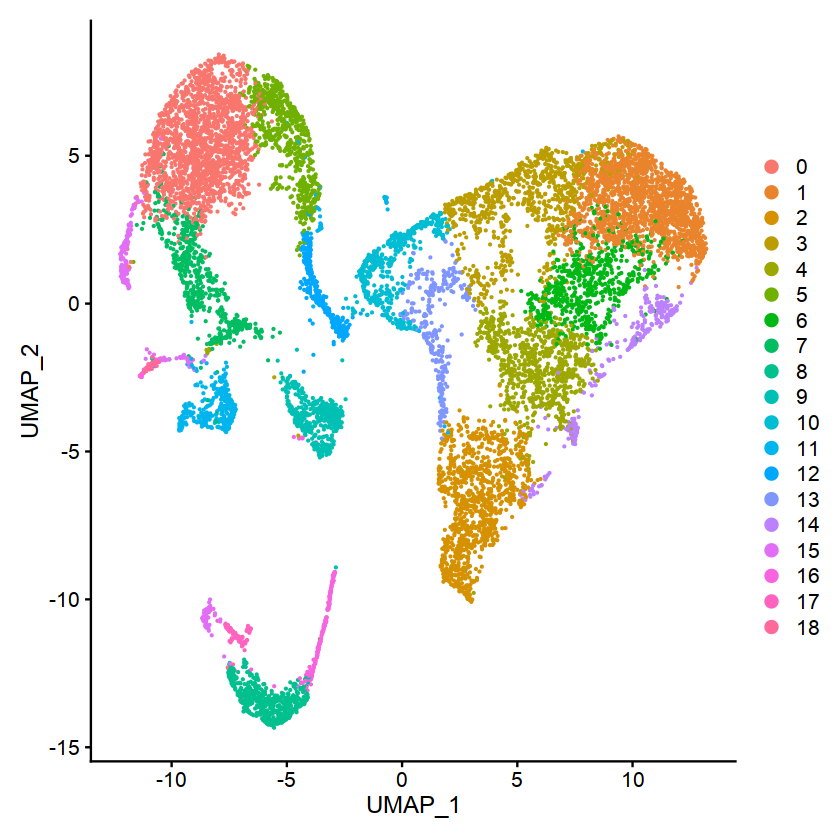

In [7]:
DimPlot(atac_pbmc_res$ATAC)

In [8]:
metadata <- read.table('example/PBMC/analysis/metadata.txt')
rownames(metadata) <- paste0(barcode_key[rownames(metadata),'RNA'],'-1')

In [11]:
unique(metadata$Celltype)

[1] "CD8T"        "CD14Mono"    "CD4T"        "CD16Mono"    "B"          
[6] "NK"          "Endothelial" "pDC"         "Plasma"

In [12]:
atac_pbmc_res$ATAC@meta.data$Celltype <- metadata[rownames(atac_pbmc_res$ATAC@meta.data),'Celltype']

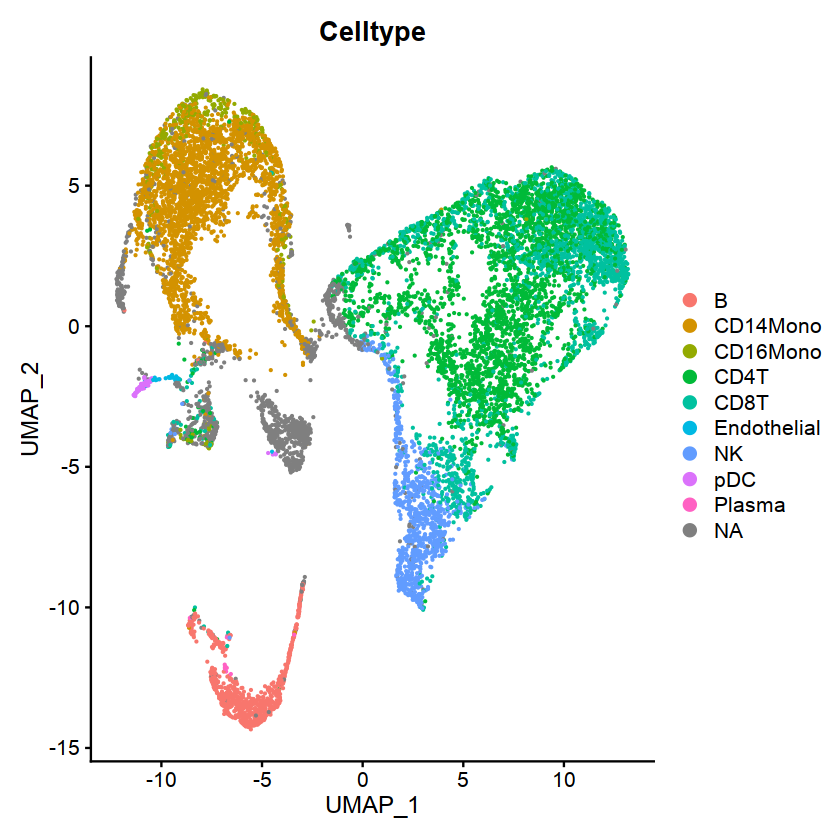

In [13]:
DimPlot(atac_pbmc_res$ATAC, group.by = 'Celltype')

In [14]:
qsave(atac_pbmc_res, 'example/PBMC/data/PBMC_ATAC_500bin/analysis/atac_pbmc_res.qs')

In [3]:
atac_pbmc_res <- qread('example/PBMC/data/PBMC_ATAC_500bin/analysis/atac_pbmc_res.qs')

In [15]:
write.table(atac_pbmc_res$ATAC@meta.data, 'example/PBMC/data/PBMC_ATAC_500bin/analysis/meta_bin.txt')

In [ ]:
atac_pbmc_res$ATAC@meta.data

In [16]:
useful_bc <- rownames(atac_pbmc_res$ATAC@meta.data)[atac_pbmc_res$ATAC@meta.data[,'Celltype'] %in% c('CD14Mono', 'CD16Mono', 'CD4T', 'CD8T', 'B')]

In [17]:
DefaultAssay(atac_pbmc_res$ATAC) <- 'ATAC'

In [18]:
atac_pbmc_se <- as.SingleCellExperiment(atac_pbmc_res$ATAC[,useful_bc])

In [19]:
saveRDS(atac_pbmc_se, 'example/PBMC/data/PBMC_ATAC_500bin/analysis/PBMC_TBMono_500bin.rds')

# H3K27ac

In [2]:
h3k27ac_pbmc_count <- Read10X_h5('example/histone/peak_base/cuttagpro/PBMC_H3K27ac_500bin/PBMC_H3K27ac_500bin_peak_count.h5')
h3k27ac_pbmc_count <- BinarizeCounts(h3k27ac_pbmc_count)

In [7]:
H3K27ac_pbmc_res <- ATACRunSeurat(inputMat = h3k27ac_pbmc_count,
                                 project = "h3k27ac",
                                 min.c = 20,
                                 min.p = 200,
                                 method = "LSI",
                                 dims.use = 1:30,
                                 cluster.res = 0.6,
                                 only.pos = TRUE,
                                 peaks.test.use = "presto",
                                 peaks.cutoff = 1e-05,
                                 peaks.pct = 0.1,
                                 peaks.logfc = 0.2,
                                 outdir = 'example/histone/peak_base/cuttagpro/PBMC_H3K27ac_500bin/analysis')

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
LSI analysis ...

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings

UMAP analysis ...

16:18:49 UMAP embedding parameters a = 0.9922 b = 1.112

16:18:49 Read 15656 rows and found 30 numeric columns

16:18:49 Using Annoy for neighbor search, n_neighbors = 30

16:18:49 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:18:51 Writing NN index file to temp file /tmp/Rtmp5pragQ/file22d8065d086e

16:18:51 Searching Annoy index using 1 thread, search_k = 3000

16:18:56 Annoy recall = 100%

16:18:58 Commencing smooth kNN distance calibration using 1 thread

16:19:02 Initializing from normalized Laplacian + noise

16:19:02 Commencing optimization for 200 epochs, with

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 15656
Number of edges: 450198

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8260
Number of communities: 8
Elapsed time: 2 seconds


Identify cluster specific peaks ...



In [9]:
H3K27ac_pbmc_res$ATAC

An object of class Seurat 
104842 features across 15656 samples within 1 assay 
Active assay: ATAC (104842 features, 104842 variable features)
 2 dimensional reductions calculated: lsi, umap

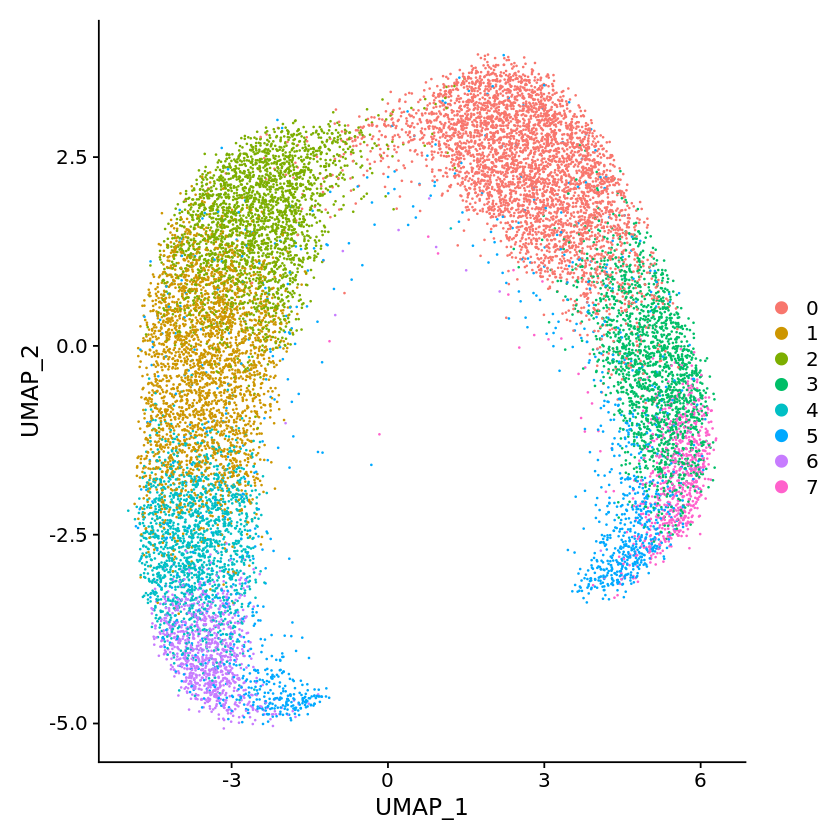

In [10]:
DimPlot(H3K27ac_pbmc_res$ATAC)

In [11]:
annotated_h3k27ac <- readRDS('example/histone/peak_base/cuttagpro/H3K27ac.rds')

In [14]:
write.table(annotated_h3k27ac@meta.data, 'example/histone/peak_base/cuttagpro/H3K27ac_metadata.txt', quote=FALSE, sep='\t')

In [15]:
metadata <- annotated_h3k27ac@meta.data

In [17]:
colnames(metadata)

[1] "orig.ident"                  "nCount_ADT"                 
 [3] "nFeature_ADT"                "nCount_HTO"                 
 [5] "nFeature_HTO"                "HTO_maxID"                  
 [7] "HTO_secondID"                "HTO_margin"                 
 [9] "HTO_classification"          "HTO_classification.global"  
[11] "hash.ID"                     "ADT_snn_res.0.5"            
[13] "seurat_clusters"             "nCount_tiles"               
[15] "nFeature_tiles"              "tiles_snn_res.0.8"          
[17] "predicted.celltype.l1.score" "predicted.celltype.l1"      
[19] "predicted.celltype.l2.score" "predicted.celltype.l2"      
[21] "predicted.celltype.l3.score" "predicted.celltype.l3"      
[23] "hand_cell"                   "tiles.weight"               
[25] "ADT.weight"                  "wsnn_res.0.3"               
[27] "cellID"                      "batch"                      
[29] "integrated.weight"

In [19]:
H3K27ac_pbmc_res$ATAC@meta.data$Celltype <- metadata[rownames(H3K27ac_pbmc_res$ATAC@meta.data),'predicted.celltype.l1']

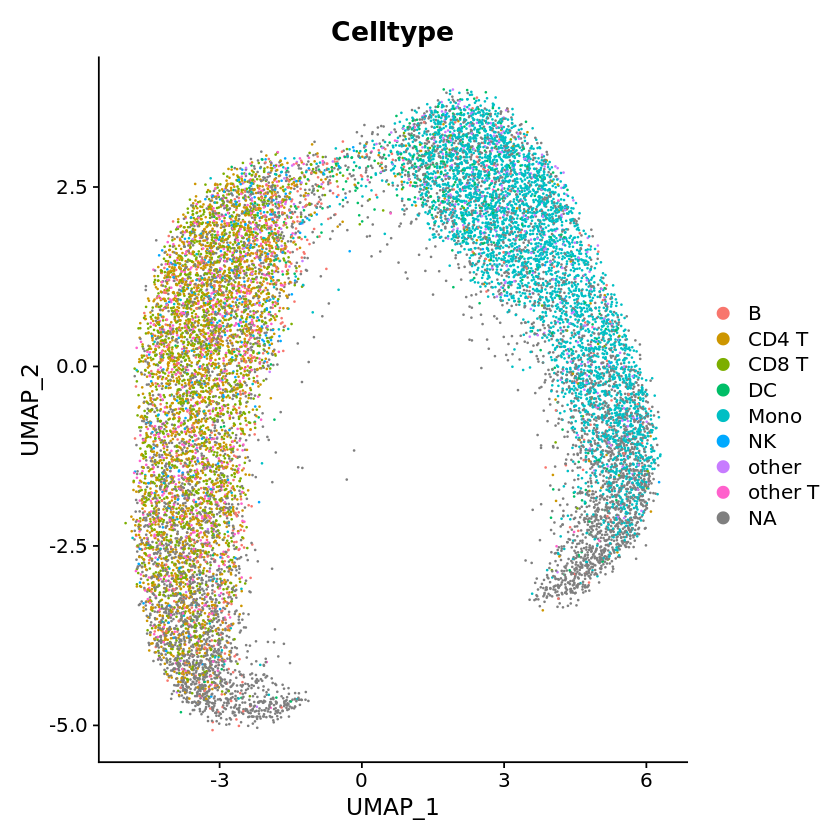

In [20]:
DimPlot(H3K27ac_pbmc_res$ATAC, group.by = 'Celltype')

In [21]:
qsave(H3K27ac_pbmc_res, 'example/histone/peak_base/cuttagpro/PBMC_H3K27ac_500bin/analysis/H3K27ac_pbmc_res.qs')

In [20]:
H3K27ac_pbmc_res <- qread('example/histone/peak_base/cuttagpro/PBMC_H3K27ac_500bin/analysis/H3K27ac_pbmc_res.qs')

In [21]:
real_h3k27ac <- as.SingleCellExperiment(H3K27ac_pbmc_res$ATAC)

In [36]:
saveRDS(real_h3k27ac, 'example/histone/peak_base/cuttagpro/PBMC_H3K27ac_500bin/analysis/real_SE.rds')

In [90]:
write.table(atac_pbmc_res$ATAC@meta.data, 'example/PBMC/data/PBMC_ATAC_500bin/analysis/meta_bin.txt')

In [ ]:
H3K27ac_pbmc_res$ATAC@meta.data

In [114]:
# useful_bc <- rownames(atac_pbmc_res$ATAC@meta.data)[atac_pbmc_res$ATAC@meta.data[,'Celltype'] %in% c('CD14+Mono', 'FCGR3A+Mono', 'CD4T', 'CD8T', 'B')]

# DefaultAssay(atac_pbmc_res$ATAC) <- 'ATAC'

# atac_pbmc_se <- as.SingleCellExperiment(atac_pbmc_res$ATAC[,useful_bc])

# saveRDS(atac_pbmc_se, 'example/PBMC/data/PBMC_ATAC_500bin/analysis/PBMC_TBMono_500bin.rds')



# impute H3K27ac

In [199]:
atac_imputed_h3k27ac_count <- Read10X('example/histone/peak_base/cuttagpro/SCRIP_PBMC/imputationPBMC0613_not_remove/H3K27ac/imputed_H3K27ac_mtx/', gene.column = 1)

In [200]:
dim(atac_imputed_h3k27ac_count)

[1] 602709   9258

In [201]:
atac_impute_h3k27ac_res <- ATACRunSeurat(inputMat = atac_imputed_h3k27ac_count,
                                         project = "h3k27ac",
                                         min.c = 200,
                                         min.p = 2000,
                                         method = "LSI",
                                         dims.use = 1:30,
                                         cluster.res = 0.6,
                                         only.pos = TRUE,
                                         peaks.test.use = "presto",
                                         peaks.cutoff = 1e-05,
                                         peaks.pct = 0.1,
                                         peaks.logfc = 0.2,
                                         outdir = 'example/histone/peak_base/cuttagpro/SCRIP_PBMC/imputationPBMC0613/analysis')

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
LSI analysis ...

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings

UMAP analysis ...

20:07:18 UMAP embedding parameters a = 0.9922 b = 1.112

20:07:18 Read 8900 rows and found 30 numeric columns

20:07:18 Using Annoy for neighbor search, n_neighbors = 30

20:07:18 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:07:19 Writing NN index file to temp file /tmp/Rtmpa3GGyR/filee4796e361304

20:07:19 Searching Annoy index using 1 thread, search_k = 3000

20:07:22 Annoy recall = 100%

20:07:27 Commencing smooth kNN distance calibration using 1 thread

20:07:35 Initializing from normalized Laplacian + noise

20:07:35 Commencing optimization for 500 epochs, with 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8900
Number of edges: 281171

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8965
Number of communities: 13
Elapsed time: 0 seconds


Identify cluster specific peaks ...



In [202]:
atac_impute_h3k27ac_res$ATAC

An object of class Seurat 
103096 features across 8900 samples within 1 assay 
Active assay: ATAC (103096 features, 103096 variable features)
 2 dimensional reductions calculated: lsi, umap

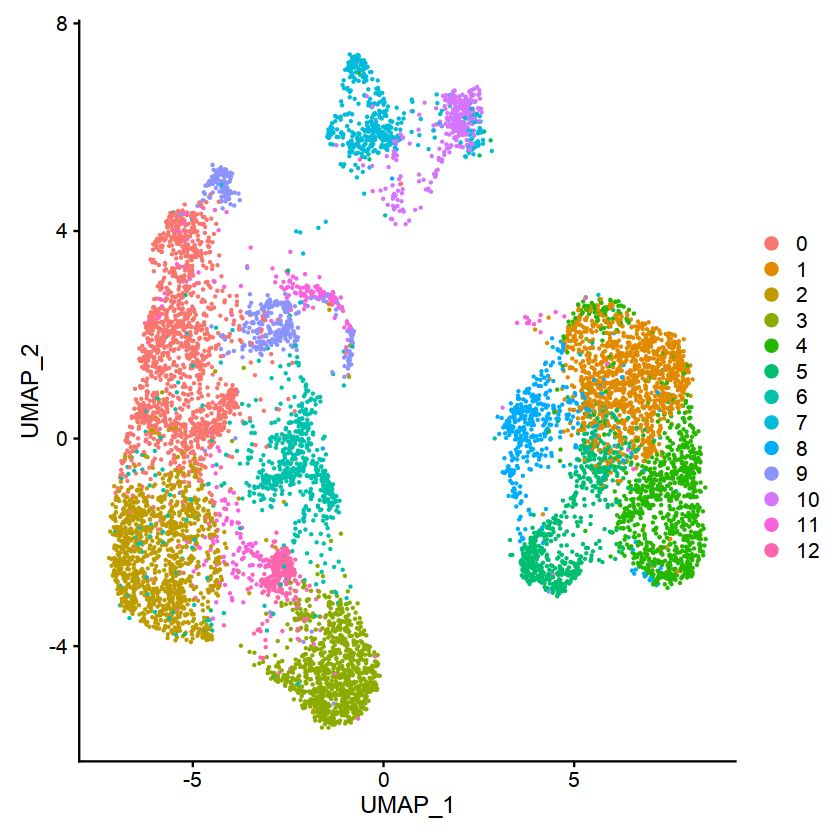

In [203]:
DimPlot(atac_impute_h3k27ac_res$ATAC)

In [187]:
celltype_key <- data.frame(paste0(rownames(imputed_metadata),'-1'),imputed_metadata$Celltype)
colnames(celltype_key) <- c('barcode', 'Celltype')
rownames(celltype_key) <- celltype_key$barcode

In [204]:
atac_impute_h3k27ac_res$ATAC@meta.data$Celltype <- celltype_key[rownames(atac_impute_h3k27ac_res$ATAC@meta.data),'Celltype']

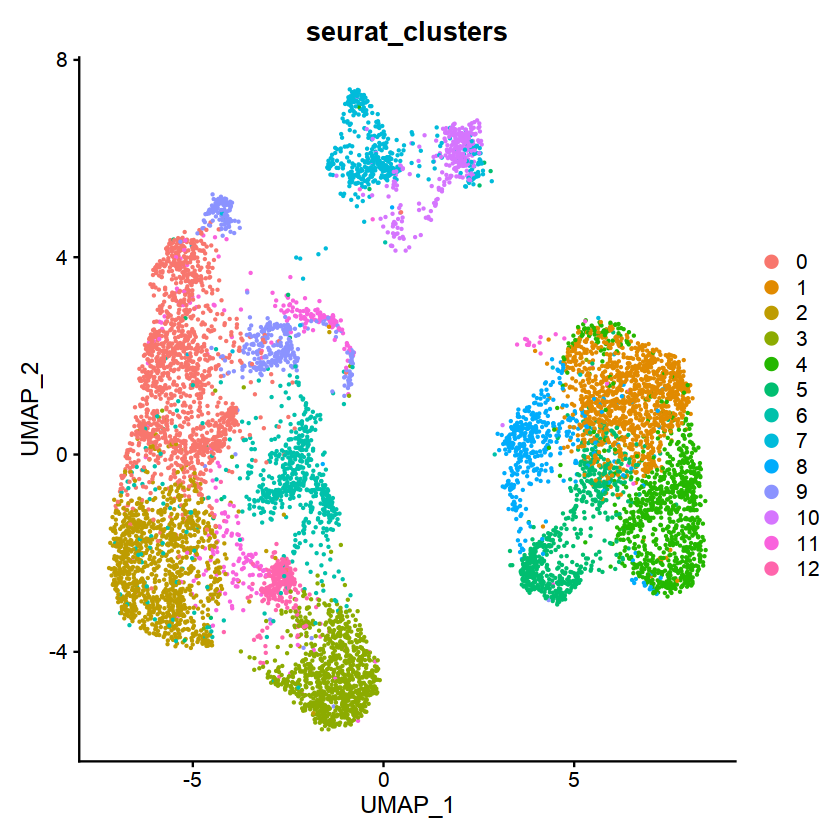

In [209]:
DimPlot(atac_impute_h3k27ac_res$ATAC, group.by = 'seurat_clusters')

In [214]:
impute_t_bc <- rownames(atac_impute_h3k27ac_res$ATAC@meta.data)[which(atac_impute_h3k27ac_res$ATAC@meta.data$seurat_clusters == 9|
                                                                       atac_impute_h3k27ac_res$ATAC@meta.data$seurat_clusters == 0|
                                                                       atac_impute_h3k27ac_res$ATAC@meta.data$seurat_clusters == 12|
                                                                       atac_impute_h3k27ac_res$ATAC@meta.data$seurat_clusters == 6|
                                                                       atac_impute_h3k27ac_res$ATAC@meta.data$seurat_clusters == 2|
                                                                       atac_impute_h3k27ac_res$ATAC@meta.data$seurat_clusters == 3|
                                                                       atac_impute_h3k27ac_res$ATAC@meta.data$seurat_clusters == 11)]

In [225]:
write(impute_mono_bc, '/fs/home/dongxin/Projects/SCRIPT/scATAC/example/histone/peak_base/cuttagpro/SCRIP_PBMC/impute_mono_bc.txt')

In [213]:
impute_mono_bc <- rownames(atac_impute_h3k27ac_res$ATAC@meta.data)[which(atac_impute_h3k27ac_res$ATAC@meta.data$seurat_clusters == 1|
                                                                           atac_impute_h3k27ac_res$ATAC@meta.data$seurat_clusters == 4|
                                                                           atac_impute_h3k27ac_res$ATAC@meta.data$seurat_clusters == 5|
                                                                           atac_impute_h3k27ac_res$ATAC@meta.data$seurat_clusters == 8)]

In [99]:
imputed_h3k27ac_se <- as.SingleCellExperiment(atac_impute_h3k27ac_res$ATAC)

In [100]:
qsave(atac_impute_h3k27ac_res, 'example/histone/peak_base/cuttagpro/SCRIP_PBMC/imputationPBMC0613_not_remove/analysis/seurat.qs')

In [185]:
atac_impute_h3k27ac_res <- qread('example/histone/peak_base/cuttagpro/SCRIP_PBMC/imputationPBMC0613/seurat.qs')

In [101]:
saveRDS(imputed_h3k27ac_se, 'example/histone/peak_base/cuttagpro/SCRIP_PBMC/imputationPBMC0613/SE.rds')

In [32]:
real_h3k27ac <- H3K27ac_pbmc_res$ATAC

In [102]:
impute_h3k27ac <- atac_impute_h3k27ac_res$ATAC

In [ ]:
h3k27ac_pbmc_count <- Read10X_h5('example/histone/peak_base/cuttagpro/PBMC_H3K27ac_500bin/PBMC_H3K27ac_500bin_peak_count.h5')
h3k27ac_pbmc_count <- BinarizeCounts(h3k27ac_pbmc_count)

In [36]:
atac_imputed_h3k27ac_count <- atac_impute_h3k27ac_res$ATAC@assays$ATAC@counts

In [ ]:
write.table(real_h3k27ac@meta.data, 'example/histone/peak_base/cuttagpro/SCRIPT_PBMC/real_meta_data.txt', quote = FALSE, sep='\t')

# generate bedgraph

In [39]:
imputed_metadata = read.csv('example/PBMC/analysis/metadata.txt', sep='\t', row.names=1)
atac_bc <- rownames(imputed_metadata)
key = read.table('example/PBMC/barcode_key.txt',sep='\t', header=TRUE)
atac_bc <- key[which(key$ATAC %in% atac_bc),'RNA']
rownames(imputed_metadata) <- atac_bc

In [42]:
# impute.pbmc.gene_10k_matrix = as.matrix(impute.pbmc.gene_10k)
real_metadata = real_h3k27ac@meta.data
# real.pbmc.gene_10k_matrix =  as.matrix(real.pbmc.gene_10k)

In [46]:
real_mono_bc = rownames(real_metadata)[which(real_metadata['Celltype'] == 'Mono')]
impute_mono_bc = rownames(imputed_metadata)[which(imputed_metadata['Celltype'] == "CD14Mono" | imputed_metadata['Celltype'] == "CD16Mono")]

In [139]:
tmp_matrix <- as.matrix(rowSums(real_h3k27ac@assays$ATAC@counts[,real_mono_bc]))
tmp_matrix <- tmp_matrix/max(tmp_matrix)
write.table(tmp_matrix, '/fs/home/dongxin/Projects/SCRIPT/scATAC/example/histone/trackplot/real_mono.bedgraph', sep='\t', col.names = FALSE, quote=FALSE)

In [220]:
# tmp_matrix <- as.matrix(rowSums(impute_h3k27ac@assays$ATAC@counts[,intersect(paste0(impute_mono_bc,'-1'), colnames(impute_h3k27ac@assays$ATAC@counts))]))
tmp_matrix <- as.matrix(rowSums(impute_h3k27ac@assays$ATAC@counts[,intersect(impute_mono_bc, colnames(impute_h3k27ac@assays$ATAC@counts))]))
tmp_matrix <- tmp_matrix/max(tmp_matrix)
write.table(tmp_matrix, '/fs/home/dongxin/Projects/SCRIPT/scATAC/example/histone/trackplot/impute_mono.bedgraph', sep='\t', col.names = FALSE, quote=FALSE)

In [221]:
# tmp_matrix <- as.matrix(rowSums(atac_pbmc_res$ATAC@assays$ATAC@counts[,intersect(paste0(impute_mono_bc,'-1'), colnames(atac_pbmc_res$ATAC@assays$ATAC@counts))]))
tmp_matrix <- as.matrix(rowSums(atac_pbmc_res$ATAC@assays$ATAC@counts[,intersect(impute_mono_bc, colnames(atac_pbmc_res$ATAC@assays$ATAC@counts))]))
tmp_matrix <- tmp_matrix/max(tmp_matrix)
write.table(tmp_matrix, '/fs/home/dongxin/Projects/SCRIPT/scATAC/example/histone/trackplot/atac_mono.bedgraph', sep='\t', col.names = FALSE, quote=FALSE)

In [58]:
real_t_bc = rownames(real_metadata)[which(real_metadata['Celltype'] == 'CD8 T' | real_metadata['Celltype'] == 'CD4 T')]
impute_t_bc = rownames(imputed_metadata)[which(imputed_metadata['Celltype'] == "CD8T" | imputed_metadata['Celltype'] == "CD4T")]

In [142]:
tmp_matrix <- as.matrix(rowSums(real_h3k27ac@assays$ATAC@counts[,real_t_bc]))
tmp_matrix <- tmp_matrix/max(tmp_matrix)
write.table(tmp_matrix, '/fs/home/dongxin/Projects/SCRIPT/scATAC/example/histone/trackplot/real_t.bedgraph', sep='\t', col.names = FALSE, quote=FALSE)

In [223]:
# tmp_matrix <- as.matrix(rowSums(impute_h3k27ac@assays$ATAC@counts[,intersect(paste0(impute_t_bc,'-1'), colnames(impute_h3k27ac@assays$ATAC@counts))]))
tmp_matrix <- as.matrix(rowSums(impute_h3k27ac@assays$ATAC@counts[,intersect(impute_t_bc, colnames(impute_h3k27ac@assays$ATAC@counts))]))
tmp_matrix <- tmp_matrix/max(tmp_matrix)
write.table(tmp_matrix, '/fs/home/dongxin/Projects/SCRIPT/scATAC/example/histone/trackplot/impute_t.bedgraph', sep='\t', col.names = FALSE, quote=FALSE)

In [222]:
# tmp_matrix <- as.matrix(rowSums(atac_pbmc_res$ATAC@assays$ATAC@counts[,intersect(paste0(impute_t_bc,'-1'), colnames(atac_pbmc_res$ATAC@assays$ATAC@counts))]))
tmp_matrix <- as.matrix(rowSums(atac_pbmc_res$ATAC@assays$ATAC@counts[,intersect(impute_t_bc, colnames(atac_pbmc_res$ATAC@assays$ATAC@counts))]))
tmp_matrix <- tmp_matrix/max(tmp_matrix)
write.table(tmp_matrix, '/fs/home/dongxin/Projects/SCRIPT/scATAC/example/histone/trackplot/atac_t.bedgraph', sep='\t', col.names = FALSE, quote=FALSE)

# GO analysis

In [2]:
T_target <- c("PER1", "JUNB", "ZFP36", "VAMP2", "CIRBP", "MIDN", "KDM6B", "PLEKHG2", "CIC", "FOSB", "JUND", "TMEM107", "ERF", "FAM174C", "TEDC1", "KLF16", "MNT", "ARHGAP45", "BORCS6", "H3C4", "H2AC7", "MAZ", "H2BC7", "CRIP1", "ING1", "PHF23", "TSEN34", "U2AF2", "MBOAT7", "GABARAP", "RPS11", "AKT1S1", "HNRNPL", "DUSP1", "H4C5", "ATP5F1D", "TBC1D17", "DBP", "CUTA", "H4C2", "GSK3A", "TMEM88", "ZNF48", "H3C2", "UBE2M", "CCDC106", "HOOK2", "WDR74", "SYNGAP1", "TRIM41", "PLEC", "ERCC1", "SIN3A", "H2AC4", "PRRT2", "PHF1", "ZNF581", "DVL2", "FBRS", "RPL13A", "MYLPF", "ZNF580", "NAA38", "TBC1D10B", "CHMP2A", "CYB5D1", "DNAJB1", "H4C1", "MZF1", "MEPCE", "FKBP2", "PTMA", "PAGR1", "LOC114841035", "FLT3LG", "PNKP", "TCTEX1D4", "U2AF1L4", "PSENEN", "BTBD19", "ZCWPW1", "POLR2E", "PRDX2", "H2BC8", "ADGRE5", "H2AC8", "H4C4", "ZNRD2", "MED29", "CCDC85B", "EIF5A", "PAF1", "UBTF", "CD248", "RPLP2", "FIBP", "CTDNEP1", "ELP5", "H3C1", "RNPEPL1", "ATXN7L3", "FAM89B", "MUS81", "ABHD17A", "C12orf57", "SCO2", "PLK3", "SARAF", "BCL9L", "CFL1", "IGFLR1", "TYMP", "KLF13", "LIN37", "BRD2", "H2BC3", "ZC3H10", "GPR137", "PRR14", "GPX4", "BAD", "ESRRA", "NR4A2", "CBARP", "HIVEP2", "TPGS1", "SEPTIN1", "PRR7", "FOS", "RPL41", "PNPLA2", "ODF3B", "ANKMY1", "H3C3", "IRF2BP2", "NAB2", "EIF4A1", "PPP1R14B", "STX5", "SRSF2", "PIDD1", "CRIP2", "PTPN6", "ZBTB22", "MFSD11", "DUSP2", "RASSF7", "LMNTD2", "ZNHIT2", "HES7", "LTBP3", "CDK4", "TAPBP", "SF1", "EHBP1L1", "ZNF524", "EMC9", "ZFP36L1", "VEGFB", "TRIM28", "TLCD1", "DUSP28", "EMP3", "ZBTB4", "ARHGDIA", "PSME2", "RNF31", "MARCHF9", "RASGRP2", "POLR2A", "FIZ1", "CA11", "SPATA2L", "RASSF1", "H3C6", "SETD1B", "ESYT1", "KLF9", "MYADM", "H2BC6", "CTDSP1", "ZNF865", "NEK8", "MKNK2", "PPP1R35", "DPAGT1", "CARS2", "H1-3", "H2AX", "KLF2", "GRK6", "IQCN", "NR1D1", "ACADVL", "BBC3", "GPS2", "YIF1A", "SOCS3", "RHOF", "DLG4", "SKI", "TECR", "ZNF784", "YWHAZ", "SLC35G6", "ALOXE3", "TM7SF2", "NR4A1", "CATSPERZ", "RAB1B", "ALDH16A1", "MVP", "SNAPC2", "METTL23", "RPL23A", "P4HB", "CCDC114", "PHRF1", "TRIM7", "LRRFIP1", "HEXIM1", "SLC25A22", "JMJD6", "EFEMP2", "LEPROTL1", "DAXX", "CARNS1", "ZBTB7A", "CKS1B", "SHC1", "PFN1", "KCNK4", "FAU", "MRPL49", "H2BC5", "HRAS", "ZNF846", "CCDC9", "DNAJC4", "AMDHD2", "PSME1", "BTG2", "LRRC56", "AP3M2", "CTSW", "RPS9", "PIH1D1", "PLCB3", "HNRNPF", "SPHK2", "CEMP1", "NPRL2", "CYB561D2", "RPS6KB2", "MTA2", "CNIH2", "ZFP36L2", "H1-1", "C2CD2L", "H2BC10", "H4C6", "DCAF11", "NRL", "ZMYND10", "PYGO2", "LOC101928120", "RARA", "C17orf49", "HNRNPUL1", "CDK9", "GMEB2", "PBXIP1", "RAB34", "TUBB4B", "ENO3", "KLF6", "RTN2", "USP5", "H1-4", "ZBTB45", "TMEM151A", "CD68", "RPS2", "ACTB", "CXCR4", "RNF44", "PPM1N", "NEURL4", "UNK", "EGLN2", "ATP6V0C", "FOSL1", "REXO1", "TRMT112", "TSPAN31", "H3C8", "PIP4P1", "HNRNPUL2", "GZF1", "ZNF837")

In [3]:
gene_entriz <- bitr(T_target, fromType="SYMBOL", toType=c("ENTREZID"), OrgDb="org.Hs.eg.db")

go <-enrichGO(gene_entriz$ENTREZID, OrgDb = org.Hs.eg.db, ont='BP',
               pAdjustMethod = 'BH',
               qvalueCutoff = 0.05,
               keyType = 'ENTREZID')

Loading required package: org.Hs.eg.db

Loading required package: AnnotationDbi


Attaching package: 'AnnotationDbi'


The following object is masked from 'package:clusterProfiler':

    select


The following object is masked from 'package:dplyr':

    select




'select()' returned 1:1 mapping between keys and columns



In [4]:
go[]

ID        
GO:0006334 GO:0006334
GO:0034728 GO:0034728
GO:0031497 GO:0031497
GO:0006333 GO:0006333
GO:0040029 GO:0040029
GO:0045814 GO:0045814
GO:0071824 GO:0071824
GO:0006323 GO:0006323
GO:0065004 GO:0065004
GO:0097549 GO:0097549
GO:0034401 GO:0034401
GO:0060968 GO:0060968
GO:0006335 GO:0006335
GO:0034723 GO:0034723
GO:0000183 GO:0000183
GO:0071103 GO:0071103
GO:0060964 GO:0060964
GO:0060147 GO:0060147
GO:0060966 GO:0060966
GO:0031507 GO:0031507
GO:0006338 GO:0006338
GO:0006352 GO:0006352
GO:0070828 GO:0070828
GO:0045637 GO:0045637
GO:0030219 GO:0030219
GO:0045652 GO:0045652
GO:0030099 GO:0030099
GO:1903706 GO:1903706
GO:0045638 GO:0045638
GO:0032200 GO:0032200
⋮          ⋮         
GO:0008213 GO:0008213
GO:0006402 GO:0006402
GO:0031057 GO:0031057
GO:0002683 GO:0002683
GO:0002227 GO:0002227
GO:0030522 GO:0030522
GO:0031055 GO:0031055
GO:0031960 GO:0031960
GO:0018022 GO:0018022
GO:1901654 GO:1901654
GO:0045577 GO:0045577
GO:0006614 GO:0006614
GO:0030183 GO:0030183
GO:1905269 GO:1905269
GO:0031936 GO:0031936
GO:0006336 GO:0006336
GO:0006613 GO:0006613
GO:0034724 GO:0034724
GO:0048308 GO:0048308
GO:0048313 GO:0048313
GO:0006401 GO:0006401
GO:1903313 GO:1903313
GO:0010639 GO:0010639
GO:0034508 GO:0034508
GO:0044344 GO:0044344
GO:0051348 GO:0051348
GO:0090316 GO:0090316
GO:2001252 GO:2001252
GO:1903749 GO:1903749
GO:0031056 GO:0031056
           Description                                                                  
GO:0006334 nucleosome assembly                                                          
GO:0034728 nucleosome organization                                                      
GO:0031497 chromatin assembly                                                           
GO:0006333 chromatin assembly or disassembly                                            
GO:0040029 regulation of gene expression, epigenetic                                    
GO:0045814 negative regulation of gene expression, epigenetic                           
GO:0071824 protein-DNA complex subunit organization                                     
GO:0006323 DNA packaging                                                                
GO:0065004 protein-DNA complex assembly                                                 
GO:0097549 chromatin organization involved in negative regulation of transcription      
GO:0034401 chromatin organization involved in regulation of transcription               
GO:0060968 regulation of gene silencing                                                 
GO:0006335 DNA replication-dependent nucleosome assembly                                
GO:0034723 DNA replication-dependent nucleosome organization                            
GO:0000183 rDNA heterochromatin assembly                                                
GO:0071103 DNA conformation change                                                      
GO:0060964 regulation of gene silencing by miRNA                                        
GO:0060147 regulation of posttranscriptional gene silencing                             
GO:0060966 regulation of gene silencing by RNA                                          
GO:0031507 heterochromatin assembly                                                     
GO:0006338 chromatin remodeling                                                         
GO:0006352 DNA-templated transcription, initiation                                      
GO:0070828 heterochromatin organization                                                 
GO:0045637 regulation of myeloid cell differentiation                                   
GO:0030219 megakaryocyte differentiation                                                
GO:0045652 regulation of megakaryocyte differentiation                                  
GO:0030099 myeloid cell differentiation                                                 
GO:1903706 regulation of hemopoiesis                                                    
GO:0045638 negative regulation of myeloid cell differentiation    

png 
  2

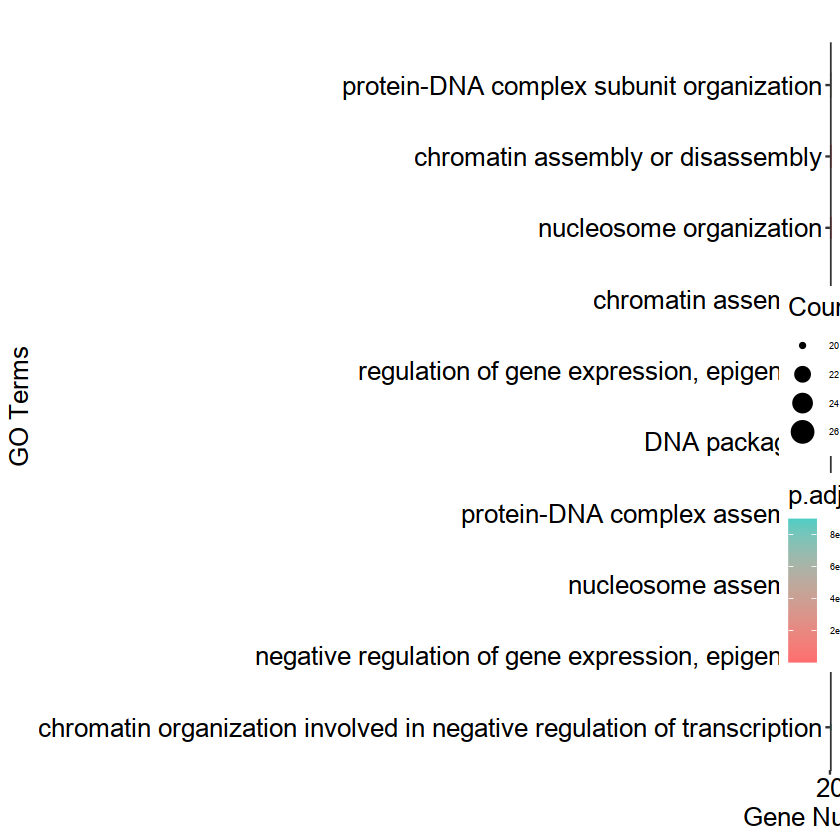

In [7]:
go<-go[order(go[1:10,9],decreasing = TRUE),]

p=ggplot(go[order(go[1:10,9],decreasing = TRUE),], aes(Description, Count))+
         geom_point(aes(color=p.adjust, size=Count))+
         labs(x = "GO Terms",y = "Gene Numbers",title = "") + 
        coord_flip()+
        theme_bw() +
        theme(panel.grid = element_blank())+
        theme(plot.title = element_text(hjust = 0.5, size = 15), 
              axis.text.y = element_text(size = 15,color='black'),
              axis.text.x = element_text(size = 15,color='black'), 
              axis.title.y = element_text(size = 15),
              axis.title.x = element_text(size = 15),
              legend.title = element_text(size = 15),
              legend.text = element_text(size = 5),
              text = element_text(hjust = 0.5))+
        scale_color_continuous(low='#FF6D6F',high='#4ecdc4')+
        scale_x_discrete(limits = rev(go$Description))+
#         theme(text = element_text(size=40,family="Arial"))+
        scale_y_continuous(breaks=seq(0,25,10))+
        theme(legend.position=c(0.8,0.4))
p

pdf(file = "Figures/H3K27ac_T_GO.pdf", width = 8, height = 6)
print(p)
dev.off()

In [8]:
mono_target <- c("ZFP36", "PLEKHG2", "KDM6B", "ODF3B", "TYMP", "MIDN", "SCO2", "ERCC1", "JUNB", "DUSP1", "FOSB", "CIRBP", "PER1", "TSEN34", "MED29", "MBOAT7", "PAF1", "MNT", "JUND", "FOS", "RPS9", "TMEM88", "MYADM", "BTBD19", "TCTEX1D4", "ATP5F1D", "VAMP2", "UBE2M", "LRRFIP1", "MZF1", "AKT1S1", "NAA38", "TBC1D17", "CYB5D1", "CTDSP1", "FTH1", "IFI30", "CIC", "FAM174C", "CHMP2A", "TEDC1", "EIF4A1", "WDR74", "IRF1", "FKBP2", "LOC114841035", "CRIP1", "OSM", "VIM", "KLF16", "KLF2", "GABARAP", "CD68", "SSBP4", "PHF23", "PLK3", "NANOS3", "FBRS", "TMEM107", "ESRRA", "ING1", "CBARP", "THEMIS2", "FOXO3", "SOCS3", "PNKP", "PNPLA2", "BORCS6", "KLHDC7B", "GPX4", "STX5", "ERF", "USP3", "RPS16", "HNRNPL", "PTMA", "BRD2", "LOC100996842", "NR4A1", "MPDU1", "CTDNEP1", "ELP5", "PLAUR", "ADGRE5", "ATF3", "CD74", "RARA", "CDK9", "PPP1R14B", "RPLP2", "IQCN", "CATSPERZ", "PRR14", "U2AF2", "SP1", "FOSL2", "CCDC9", "H3-3B", "NR1D1", "U2AF1L4", "PSENEN", "MKNK2", "SH2D3C", "PDE4A", "DBP", "POLR2E", "ATP6V0C", "AMDHD2", "DVL2", "CARD19", "UNK", "HNRNPF", "MYLPF", "P4HB", "SKI", "GPR137", "BBC3", "LMNA", "TBC1D10B", "SLC11A1", "KLF6", "BAD", "CASP9", "MCL1", "GRK6", "VEGFB", "TAGLN2", "PIM3", "TRIM8", "B2M", "RFX1", "ANKMY1", "LIN37", "WDR81", "NR4A2", "GSK3A", "TRIM28", "MEPCE", "RNPEPL1", "ATG16L2", "DENND4B", "CEMP1", "ARHGDIA", "BEST1", "IGFLR1", "PRDX2", "STK40", "FAM89B", "ZCWPW1", "SENP3", "MED11", "HOOK2", "ZNRD2", "MPV17L2", "EHD1", "DUSP28", "TRMT112", "DNAJC16", "CCDC85B", "EHBP1L1", "PRDX5", "KLF4", "PTPN6", "C12orf57", "LFNG", "FIBP", "DENND3", "ANKRD13D", "NR4A3", "SIN3A", "C17orf49", "TLCD1", "CRIP2", "RALGDS", "PLEC", "MTX1", "TAPBP", "KCNK4", "IBA57", "PIDD1", "PLCB3", "DNAJC4", "RPL23A", "EIF5A", "MOB3A", "THBS3", "MEF2D", "NEK8", "METTL23", "BHLHE40", "JMJD6", "ZFP36L2", "ZNF48", "RNF31", "PSME2", "H2AX", "PILRA", "ZBTB22", "ARHGAP45", "RGL2", "PFN1", "CCDC106", "DPAGT1", "IZUMO4", "VASP", "KAT8", "GZF1", "CRACR2B", "OAZ1", "GNAI2", "BCL3", "BTG2", "ZMYND15", "ARRB2", "C2CD2L", "RNASEK", "RTN2", "ATP2B1", "CXCL16", "IRF2BP2", "PRKACA", "RAB34", "TRABD", "H3C4", "H2AC7", "QKI", "PPM1N", "H2BC7", "TNFSF13", "FAAP20", "ZBTB7A", "CFL1", "SPHK2", "MROH6", "MUS81", "RASSF1", "PIK3R2", "H4C5", "ENO3", "MFSD11", "CDC37", "MAZ", "GSDMD", "NXF1", "RPS11", "SRSF2", "CARS2", "PDLIM7", "EMC9", "RHBDF2", "METRNL", "RPS2", "SERTAD3", "USP4", "DNAJB1", "HEXIM1", "GPSM3", "ZBTB45", "TRIB1", "SHC1", "CKS1B", "PPCDC", "ZNF672", "ZNF581", "PDPK1", "ABHD17A", "ADAT3", "SCAMP4", "HYAL3", "NAA80", "EIF1", "ARID5A", "NDUFAF3", "DOK3", "DOT1L", "ATXN7L3", "UBE2D3", "DALRD3", "PHF1", "PPP1R35", "SLC16A3", "ALDOA", "SLC25A22", "ADAMTSL4", "AHNAK", "ZNF580", "FAM214B", "RNF151", "INAFM1", "ACTB", "IL4I1", "ZC3H10", "NUDT22", "TRPT1", "NOTCH1", "CUTA", "PGS1", "PRKCG", "ZNF687", "CD300LB")

In [9]:
gene_entriz <- bitr(mono_target, fromType="SYMBOL", toType=c("ENTREZID"), OrgDb="org.Hs.eg.db")

go <-enrichGO(gene_entriz$ENTREZID, OrgDb = org.Hs.eg.db, ont='BP',
               pAdjustMethod = 'BH',
               qvalueCutoff = 0.05,
               keyType = 'ENTREZID')

'select()' returned 1:1 mapping between keys and columns



In [61]:
go[]

ID        
GO:0030099 GO:0030099
GO:1903706 GO:1903706
GO:0040029 GO:0040029
GO:1903311 GO:1903311
GO:1901653 GO:1901653
GO:0045637 GO:0045637
GO:0006979 GO:0006979
GO:0006367 GO:0006367
GO:0071375 GO:0071375
GO:0051098 GO:0051098
GO:0048545 GO:0048545
GO:0019083 GO:0019083
GO:0007568 GO:0007568
GO:0043523 GO:0043523
GO:0090316 GO:0090316
GO:0006352 GO:0006352
GO:0050684 GO:0050684
GO:0014020 GO:0014020
GO:0043484 GO:0043484
GO:0043434 GO:0043434
GO:0032388 GO:0032388
GO:1903707 GO:1903707
GO:0038034 GO:0038034
GO:0097192 GO:0097192
GO:0006417 GO:0006417
GO:1900153 GO:1900153
GO:0032869 GO:0032869
GO:1903829 GO:1903829
GO:0019080 GO:0019080
GO:0021915 GO:0021915
⋮          ⋮         
GO:0050792 GO:0050792
GO:0035148 GO:0035148
GO:0001843 GO:0001843
GO:2001233 GO:2001233
GO:0060606 GO:0060606
GO:0006402 GO:0006402
GO:0002604 GO:0002604
GO:0051101 GO:0051101
GO:0001838 GO:0001838
GO:0002068 GO:0002068
GO:0045814 GO:0045814
GO:1901216 GO:1901216
GO:0002468 GO:0002468
GO:2001234 GO:2001234
GO:0034599 GO:0034599
GO:0002067 GO:0002067
GO:0090199 GO:0090199
GO:0043502 GO:0043502
GO:0072175 GO:0072175
GO:0061469 GO:0061469
GO:0062197 GO:0062197
GO:0070997 GO:0070997
GO:0034614 GO:0034614
GO:0030183 GO:0030183
GO:1905269 GO:1905269
GO:0032868 GO:0032868
GO:0010038 GO:0010038
GO:0051099 GO:0051099
GO:0030098 GO:0030098
GO:0000956 GO:0000956
           Description                                                                                     
GO:0030099 myeloid cell differentiation                                                                    
GO:1903706 regulation of hemopoiesis                                                                       
GO:0040029 regulation of gene expression, epigenetic                                                       
GO:1903311 regulation of mRNA metabolic process                                                            
GO:1901653 cellular response to peptide                                                                    
GO:0045637 regulation of myeloid cell differentiation                                                      
GO:0006979 response to oxidative stress                                                                    
GO:0006367 transcription initiation from RNA polymerase II promoter                                        
GO:0071375 cellular response to peptide hormone stimulus                                                   
GO:0051098 regulation of binding                                                                           
GO:0048545 response to steroid hormone                                                                     
GO:0019083 viral transcription                                                                             
GO:0007568 aging                                                                                           
GO:0043523 regulation of neuron apoptotic process                                                          
GO:0090316 positive regulation of intracellular protein transport                                          
GO:0006352 DNA-templated transcription, initiation                                                         
GO:0050684 regulation of mRNA processing                                                                   
GO:0014020 primary neural tube formation                                                                   
GO:0043484 regulation of RNA splicing                                                                      
GO:0043434 response to peptide hormone                                                                     
GO:0032388 positive regulation of intracellular transport                                                  
GO:1903707 negative regulation of hemopoiesis                                                              
GO:0038034 signal transduction in absence of ligand                                                        
GO:0097192 extrinsic apoptotic signaling pathway in abs

png 
  2

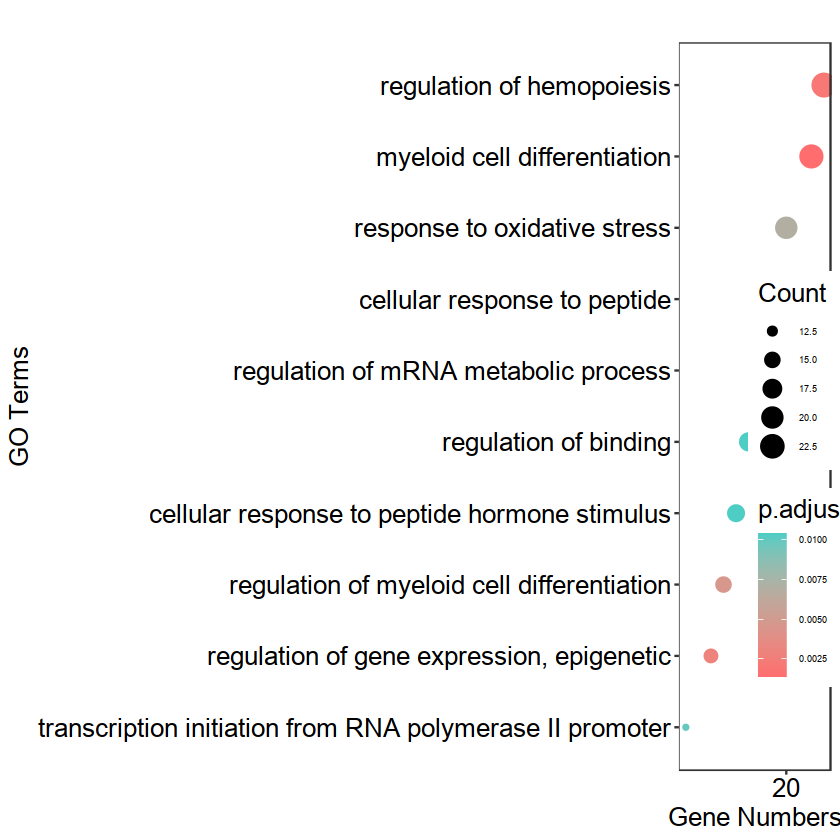

In [10]:
go<-go[order(go[1:10,9],decreasing = TRUE),]

p=ggplot(go, aes(Description, Count))+
         geom_point(aes(color=p.adjust, size=Count))+
         labs(x = "GO Terms",y = "Gene Numbers",title = "") + 
        coord_flip()+
        theme_bw() +
        theme(panel.grid = element_blank())+
        theme(plot.title = element_text(hjust = 0.5, size = 15), 
              axis.text.y = element_text(size = 15,color='black'),
              axis.text.x = element_text(size = 15,color='black'), 
              axis.title.y = element_text(size = 15),
              axis.title.x = element_text(size = 15),
              legend.title = element_text(size = 15),
              legend.text = element_text(size = 5),
              text = element_text(hjust = 0.5))+
        scale_color_continuous(low='#FF6D6F',high='#4ecdc4')+
        scale_x_discrete(limits = rev(go$Description))+
#         theme(text = element_text(size=40,family="Arial"))+
        scale_y_continuous(breaks=seq(0,25,10))+
        theme(legend.position=c(0.8,0.4))
p

pdf(file = "Figures/H3K27ac_mono_GO.pdf", width = 8, height = 6)
print(p)
dev.off()

In [31]:
bulk_mono_target = unique(read.table('/fs/home/dongxin/Projects/SCRIPT/scATAC/example/histone/34935_gene_score_5fold_Mono.txt', comment.char = '#')$V7)[0:1000]

In [34]:
venn.diagram(
  x = list(
    names(sort(real_mono_rp, decreasing = TRUE)[0:1000]), 
    names(sort(impute_mono_rp, decreasing = TRUE)[0:1000]) , 
    bulk_mono_target
    ),
  category.names = c("scCUT&Pro" , "SCRIPT Imputed" , "Bulk"),
  filename = 'venn_mono.png',
  output = TRUE ,
  imagetype="png" ,
  height = 800 , 
  width = 800 , 
  resolution = 300,
  compression = "lzw",
  lwd = 1,
  col=c("#440154ff", '#21908dff', '#fc2727ff'),
  fill = c(alpha("#440154ff",0.3), alpha('#21908dff',0.3), alpha('#fc2727ff',0.3)),
  cex = 1,
  fontfamily = "Arial",
  cat.cex = 0.7,
  cat.default.pos = "outer",
  cat.pos = c(-27, 22, 135),
  cat.dist = c(0.055, 0.055, 0.085),
  cat.fontfamily = "Arial",
  cat.col = c("#440154ff", '#21908dff', '#fc2727ff'),
  rotation = 1
        )

[1] 1

In [ ]:
REAL@assays$ACTIVITY@counts[,'TGCCTGTGTTTCACCC-2']

In [ ]:
IMPUTE@assays$ACTIVITY@counts[,'AATCCTAAGCTAATTG-1']

In [99]:
cor.test(IMPUTE@assays$ACTIVITY@counts[,'AATCCTAAGCTAATTG-1'],REAL@assays$ACTIVITY@counts[,'TGCCTGTGTTTCACCC-2'], method = 'spearman' )

Warning message in cor.test.default(IMPUTE@assays$ACTIVITY@counts[, "AATCCTAAGCTAATTG-1"], :
"Cannot compute exact p-value with ties"



	Spearman's rank correlation rho

data:  IMPUTE@assays$ACTIVITY@counts[, "AATCCTAAGCTAATTG-1"] and REAL@assays$ACTIVITY@counts[, "TGCCTGTGTTTCACCC-2"]
S = 3.3592e+12, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.1114105 


In [ ]:
REAL@meta.data

## integration

In [220]:
REAL <- real_h3k27ac
IMPUTE <- impute_h3k27ac

In [221]:
REAL = NormalizeData(REAL)
IMPUTE = NormalizeData(IMPUTE)

In [222]:
REAL$tech <- "real"
IMPUTE$tech <- "impute"

In [223]:
transfer.anchors <- FindTransferAnchors(reference = REAL, query = IMPUTE, features = VariableFeatures(object = REAL), 
                      reference.assay = "ACTIVITY", query.assay = "ACTIVITY", reduction = "cca")

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 14768 anchors

Filtering anchors

	Retained 5224 anchors



In [227]:
celltype.predictions <- TransferData(anchorset = transfer.anchors, refdata = REAL$Celltype, weight.reduction = IMPUTE[["lsi"]], dims = 1:30)

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [228]:
IMPUTE@meta.data$assign.ident <- celltype.predictions$predicted.id
IMPUTE@meta.data$prediction.score.max <- celltype.predictions$prediction.score.max

In [229]:
genes.use <- VariableFeatures(REAL)

In [230]:
length(which(VariableFeatures(IMPUTE) %in% VariableFeatures(REAL) == TRUE))

[1] 490

In [231]:
refdata <- GetAssayData(REAL, assay = "ACTIVITY", slot = "data")[genes.use, ]

In [232]:
imputation <- TransferData(anchorset = transfer.anchors, refdata = refdata, weight.reduction = IMPUTE[["lsi"]], dims = 1:30)

Finding integration vectors

Finding integration vector weights

Transfering 2000 features onto reference data



In [233]:
IMPUTE[["real"]] <- imputation

In [234]:
CombinedObj <- merge(x = REAL, y = IMPUTE)

In [236]:
CombinedObj@project.name <- 'imputation_integration'
CombinedObj <- ScaleData(CombinedObj, features = genes.use, do.scale = TRUE)
CombinedObj <- RunPCA(CombinedObj, features = genes.use, verbose = FALSE)
CombinedObj <- RunUMAP(CombinedObj, dims = 1:30)

Centering and scaling data matrix

12:45:12 UMAP embedding parameters a = 0.9922 b = 1.112

12:45:12 Read 24734 rows and found 30 numeric columns

12:45:12 Using Annoy for neighbor search, n_neighbors = 30

12:45:12 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

12:45:18 Writing NN index file to temp file /tmp/RtmpuK7Tgv/file25a762b5ac97

12:45:18 Searching Annoy index using 1 thread, search_k = 3000

12:45:26 Annoy recall = 58.06%

12:45:30 Commencing smooth kNN distance calibration using 1 thread

12:45:36 Initializing from normalized Laplacian + noise

12:45:38 Commencing optimization for 200 epochs, with 1239916 positive edges

12:46:14 Optimization finished



An object of class Seurat 
181533 features across 24734 samples within 3 assays 
Active assay: ACTIVITY (28307 features, 0 variable features)
 2 other assays present: ATAC, real
 2 dimensional reductions calculated: pca, umap

In [ ]:
CombinedObj <- RunHarmony(CombinedObj, "tech", assay.use = "ACTIVITY")
CombinedObj <- RunUMAP(CombinedObj, reduction = "harmony", dims = 1:30)

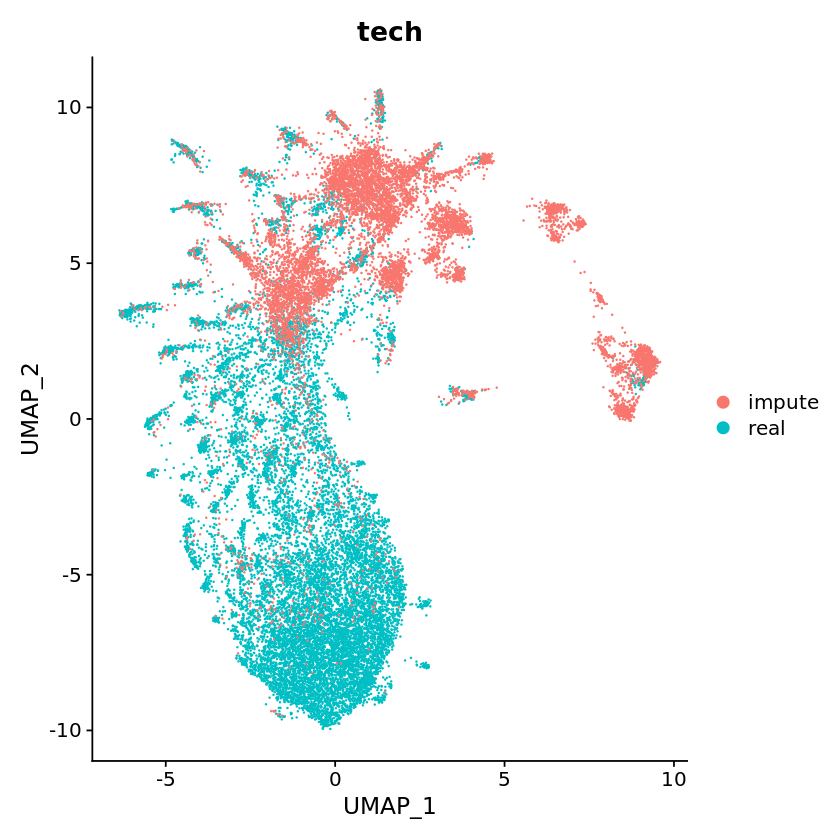

In [239]:
p1 <- DimPlot(CombinedObj, reduction = "umap", group.by = "tech", repel = TRUE)
p1
# ggsave(file.path(paste0(CombinedObj@project.name, "_source.png")), p1, width=5, height=4)

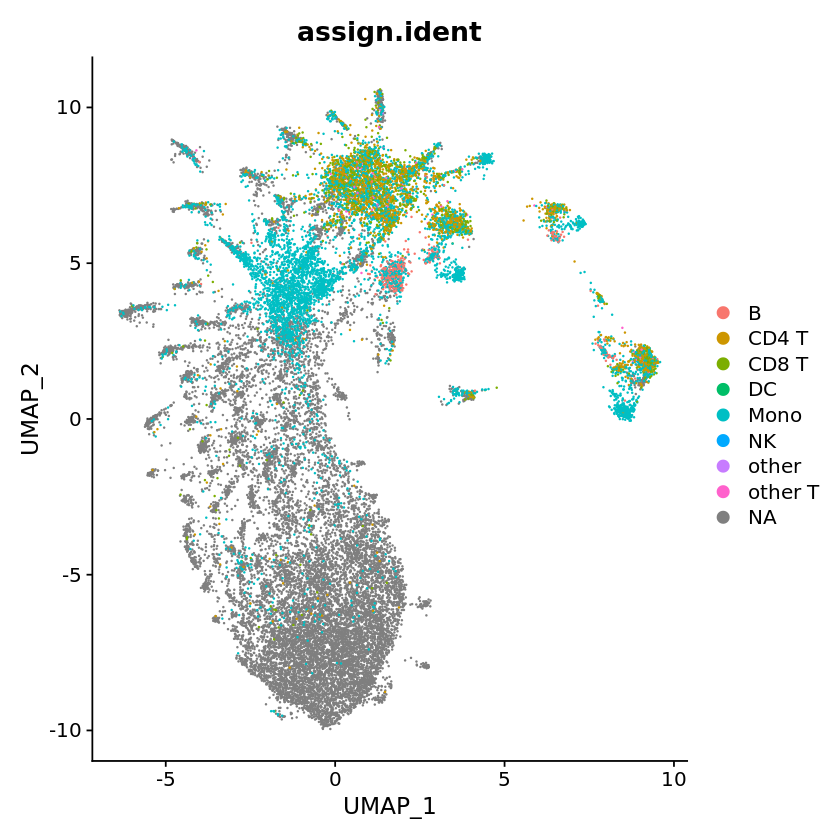

In [240]:
DimPlot(CombinedObj, reduction = "umap", group.by = "assign.ident", repel = TRUE)

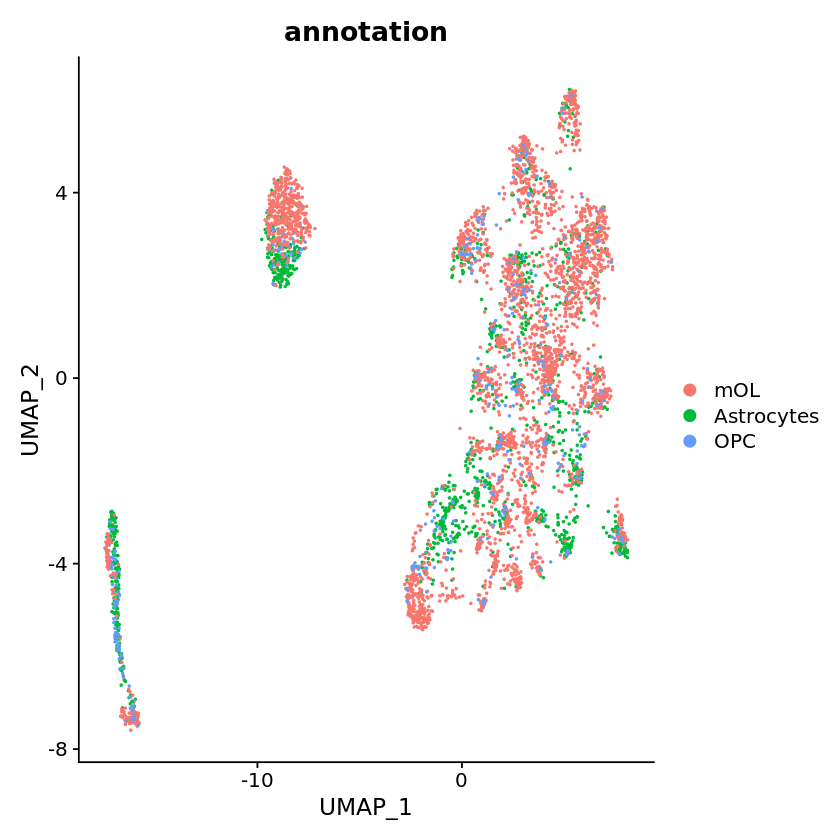

In [115]:
DimPlot(CombinedObj, reduction = "umap", group.by = "annotation", repel = TRUE)

# annotation

In [11]:
black_list <- read.table('/fs/home/dongxin/Projects/SCRIPT/scATAC/example/histone/data/matrix/mm10.blacklist.bed.gz')
black_list.gr = GRanges(
    black_list[,1], 
    IRanges(black_list[,2], black_list[,3])
  );

In [27]:
metadata <- read.csv('example/histone/data/matrix/meta_with_source.tsv', sep='\t', row.names = 1)

In [35]:
metadata <- metadata[which(metadata$Target == 'ATAC'),]

In [49]:
runSnapATAC <- function(x.sp, metadata = metadata, binary = FALSE, black_list = black_list.gr){
    if(binary == TRUE){
        x.sp = makeBinary(x.sp, mat="bmat")
    }
    # remove black list
#     idy = queryHits(
#         findOverlaps(x.sp@feature, black_list)
#       );
#     if(length(idy) > 0){
#         x.sp = x.sp[,-idy, mat="bmat"];
#       };
    # remove chrM
#     chr.exclude = seqlevels(x.sp@feature)[grep("random|chrM", seqlevels(x.sp@feature))]
#     idy = grep(paste(chr.exclude, collapse="|"), x.sp@feature)
#     if(length(idy) > 0){
#         x.sp = x.sp[,-idy, mat="bmat"]
#       };
    # cal bin coverage
    bin.cov = log10(Matrix::colSums(x.sp@bmat)+1);
#     hist(
#         bin.cov[bin.cov > 0], 
#         xlab="log10(bin cov)", 
#         main="log10(Bin Cov)", 
#         col="lightblue", 
#         xlim=c(0, 5)
#       );
    bin.cutoff = quantile(bin.cov[bin.cov > 0], 0.95)
    idy = which(bin.cov <= bin.cutoff & bin.cov > 0)
    x.sp = x.sp[, idy, mat="bmat"];
    # processing
    x.sp = runDiffusionMaps(
        obj=x.sp,
        input.mat="bmat", 
        num.eigs=50
      );
    x.sp = runKNN(
        obj=x.sp,
        eigs.dims=1:20,
        k=15
      );
    x.sp=runCluster(
        obj=x.sp,
        tmp.folder=tempdir(),
        louvain.lib="R-igraph",
        seed.use=10
      );
    tmpmeta = data.frame(x.sp@barcode, metadata[x.sp@barcode,'Annotation'],  metadata[x.sp@barcode,'Tissue'], metadata[x.sp@barcode,'H3K27ac'], metadata[x.sp@barcode,'H3K4me1'], row.names = x.sp@barcode)
    colnames(tmpmeta) <- c('barcode', 'annotation', 'tissue', 'H3K27ac', 'H3K4me1')
    x.sp@metaData <- tmpmeta
    x.sp@metaData$cluster = x.sp@cluster
    plotDimReductPW(
        obj=x.sp, 
        eigs.dims=1:50,
        point.size=0.3,
        point.color="grey",
        point.shape=19,
        point.alpha=0.6,
        down.sample=5000,
        pdf.file.name=NULL, 
        pdf.height=7, 
        pdf.width=7
      )
    x.sp = runViz(
        obj=x.sp, 
        tmp.folder=tempdir(),
        dims=2,
        eigs.dims=1:10, 
        method="umap",
        seed.use=10
      )
}

# H3K27ac

In [18]:
mm = readMM('example/histone/data/matrix/04.Paired-Tag_H3K27ac_DNA_filtered_matrix/matrix.mtx')
bc = read.csv('example/histone/data/matrix/04.Paired-Tag_H3K27ac_DNA_filtered_matrix/barcodes.tsv', header = FALSE)$V1
bin = GRanges(read.csv('example/histone/data/matrix/04.Paired-Tag_H3K27ac_DNA_filtered_matrix/bins.tsv', sep = '\t', header = FALSE)$V1)

In [110]:
k27ac.sp <- createSnapFromBmat(t(as.sparse(mm)), barcodes = bc, bins = bin)

In [ ]:
k27ac.sp <- runSnapATAC(k27ac.sp)

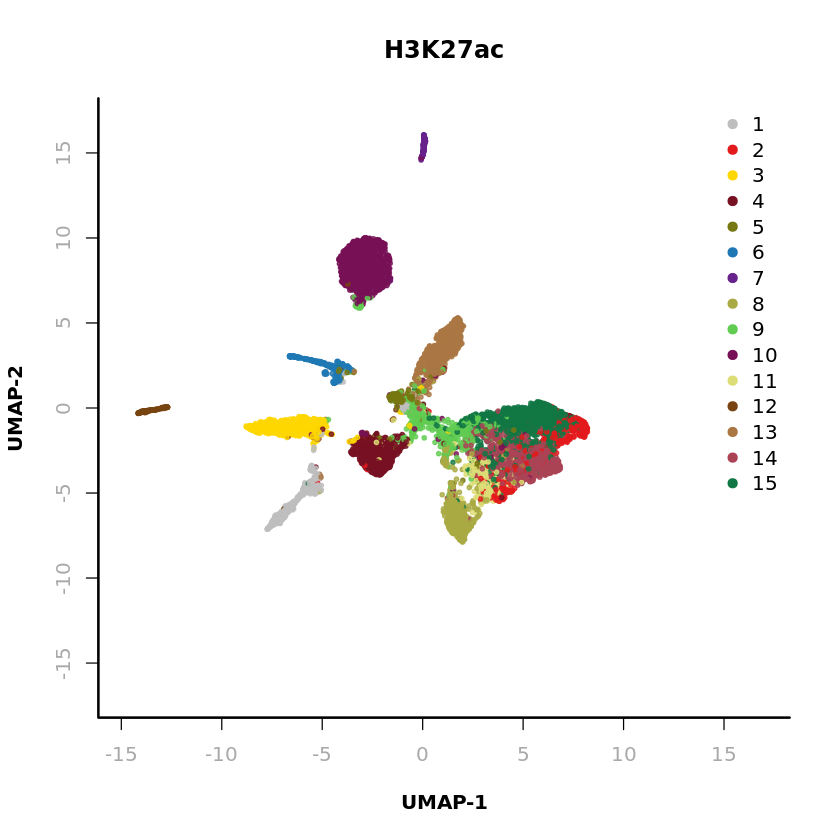

In [140]:
plotViz(
    obj=k27ac.sp,
    method="umap", 
    main="H3K27ac Cluster",
    point.color=k27ac.sp@cluster, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='right'
  )

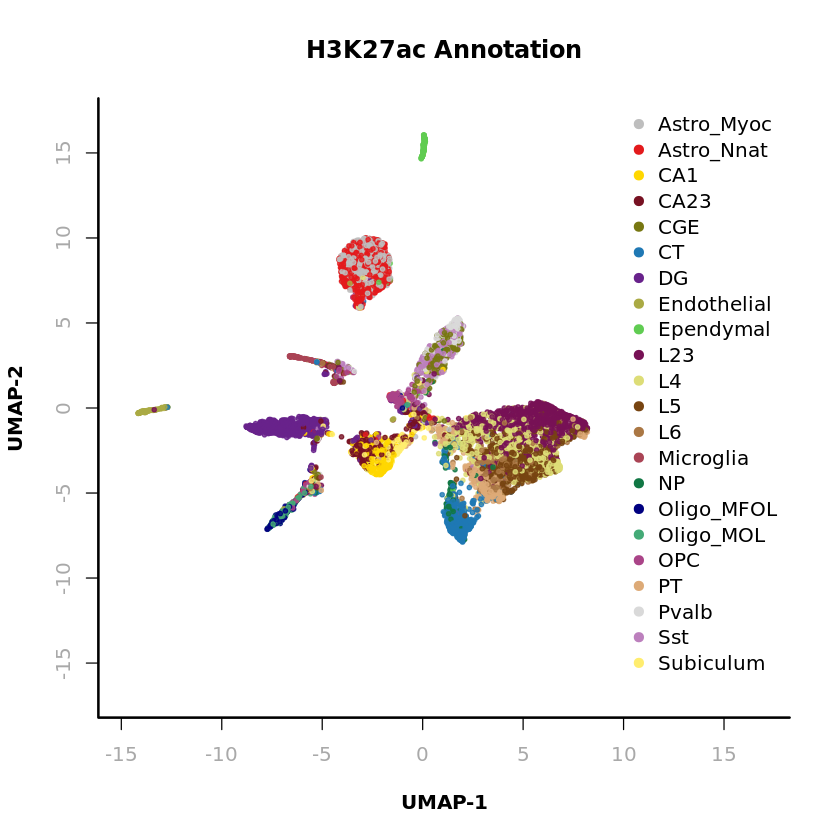

In [196]:
plotViz(
    obj=k27ac.sp,
    method="umap", 
    main="H3K27ac Annotation",
    point.color=k27ac.sp@metaData$annotation, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='right',
  )

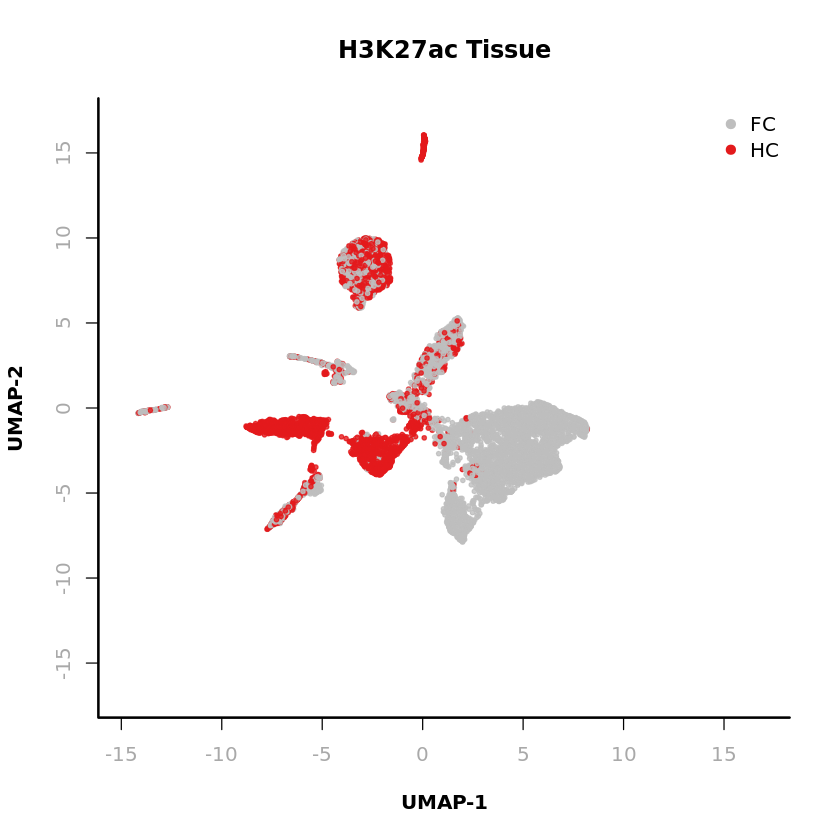

In [191]:
plotViz(
    obj=k27ac.sp,
    method="umap", 
    main="H3K27ac Tissue",
    point.color=k27ac.sp@metaData$tissue, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='right'
  )

# imputed H3K27ac

In [66]:
mm = readMM('example/histone/SCRIPT/imputation/mtx_imputed_H3K27ac/matrix.mtx')
bc = read.csv('example/histone/SCRIPT/imputation/mtx_imputed_H3K27ac/barcodes.tsv', header = FALSE)$V1
bin = GRanges(read.csv('example/histone/SCRIPT/imputation/mtx_imputed_H3K27ac/bins.tsv', sep = '\t', header = FALSE)$V1)

In [67]:
bin = GRanges(read.csv('example/histone/SCRIPT/imputation/mtx_imputed_H3K27ac/bins.tsv', sep = '\t', header = FALSE)$V1)

In [68]:
k27ac.impute <- createSnapFromBmat(as.sparse(mm), barcodes = bc, bins = bin)

Epoch: checking the inputs ...

Epoch: computing jaccard similarity matrix ...

Epoch: fitting regression model ...

Epoch: performing normalization ...

Epoch: computing eigen decomposition ...

Epoch: Done



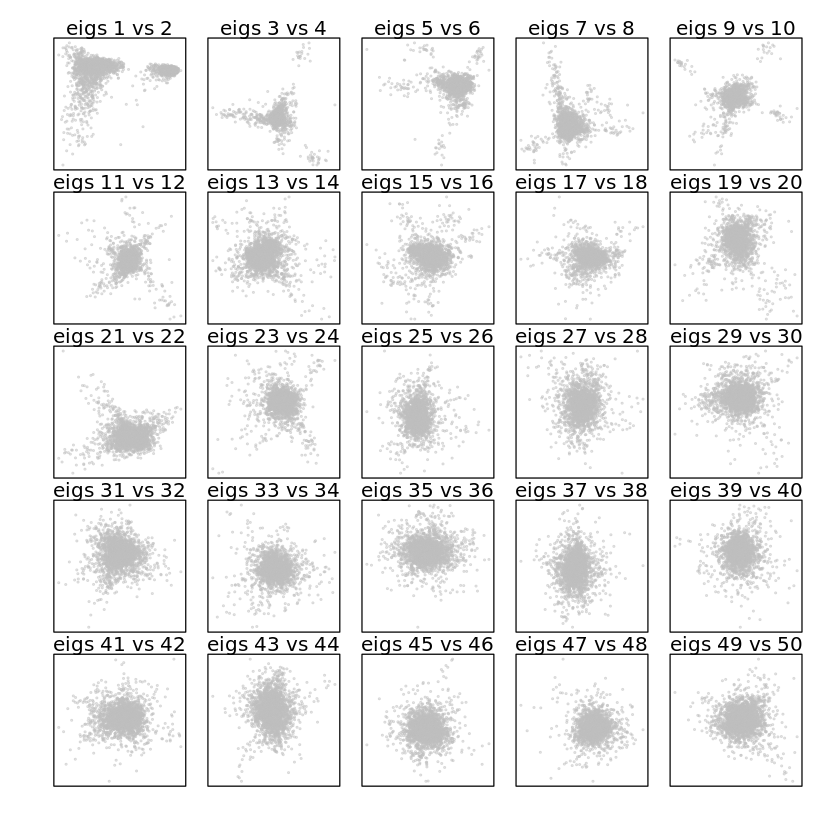

In [70]:
k27ac.impute <- runSnapATAC(k27ac.impute, metadata)

In [71]:
k27ac.impute

number of barcodes: 14095
number of bins: 49135
number of genes: 0
number of peaks: 0
number of motifs: 0

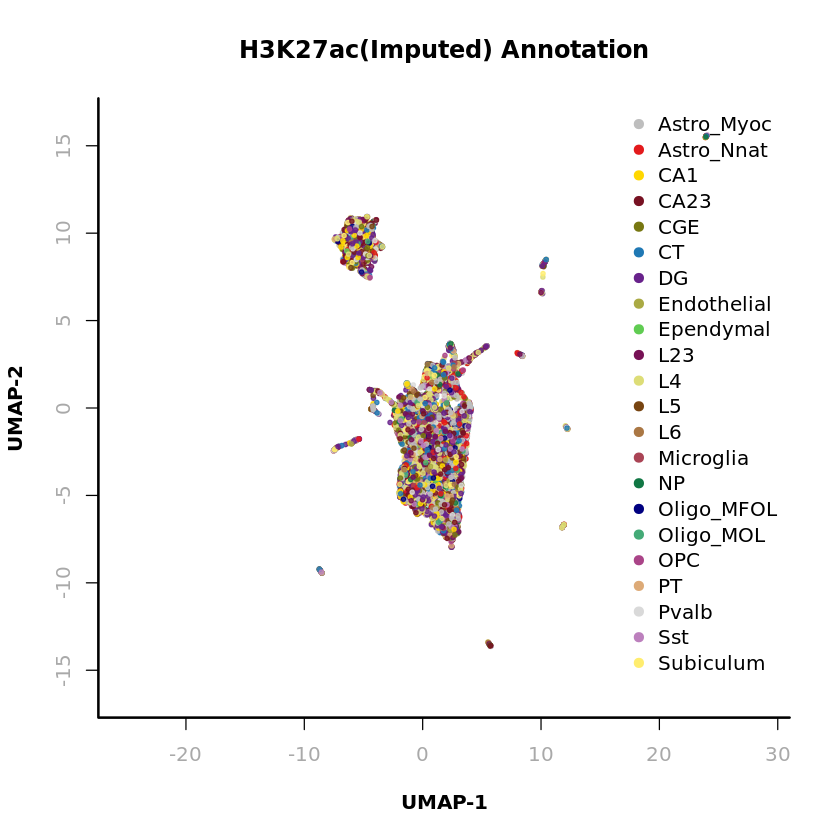

In [72]:
plotViz(
    obj=k27ac.impute,
    method="umap", 
    main="H3K27ac(Imputed) Annotation",
    point.color=k27ac.impute@metaData$annotation, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='right',
  )

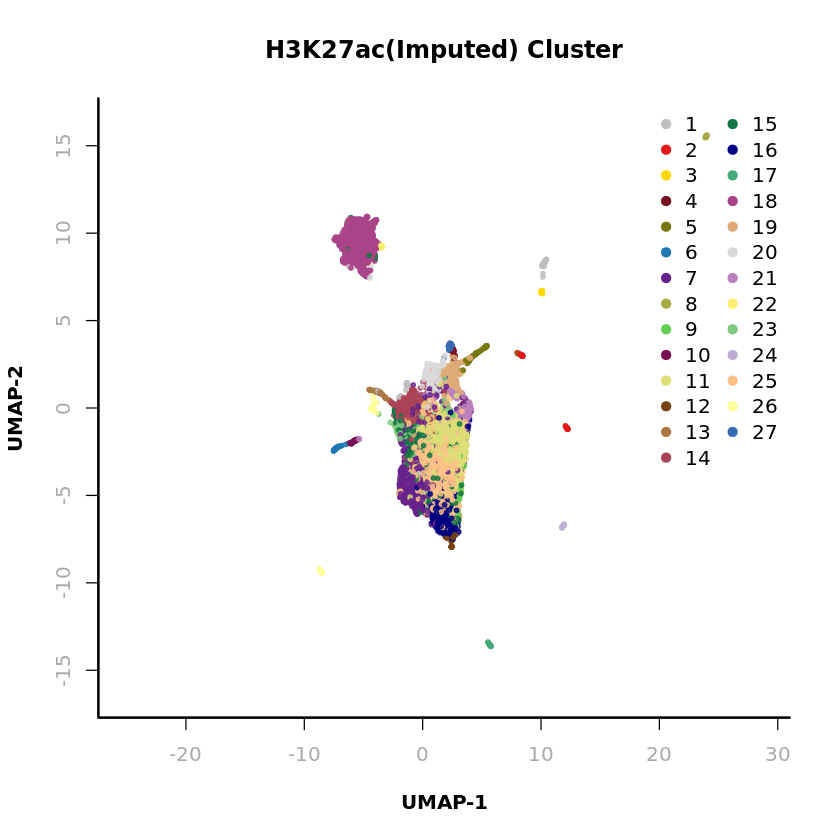

In [79]:
plotViz(
    obj=k27ac.impute,
    method="umap", 
    main="H3K27ac(Imputed) Cluster",
    point.color=k27ac.impute@cluster, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='right',
  )

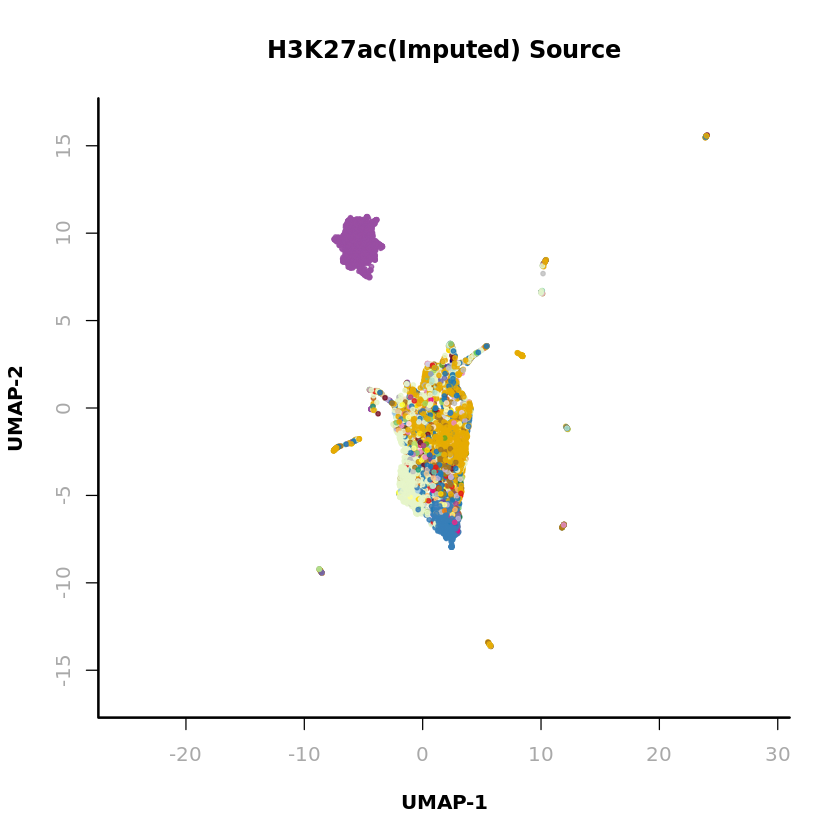

In [78]:
plotViz(
    obj=k27ac.impute,
    method="umap", 
    main="H3K27ac(Imputed) Source",
    point.color=k27ac.impute@metaData$H3K27ac, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=FALSE,
    legend.pos='right',
  )

# H3K4me1

In [15]:
mm = readMM('example/histone/data/matrix/02.Paired-Tag_H3K4me1_DNA_filtered_matrix/matrix.mtx')
bc = read.csv('example/histone/data/matrix/02.Paired-Tag_H3K4me1_DNA_filtered_matrix/barcodes.tsv', header = FALSE)$V1
bin = GRanges(read.csv('example/histone/data/matrix/02.Paired-Tag_H3K4me1_DNA_filtered_matrix/bins.tsv', sep = '\t', header = FALSE)$V1)

In [16]:
k4me1.sp <- createSnapFromBmat(t(as.sparse(mm)), barcodes = bc, bins = bin)

In [67]:
bin.cov = log10(Matrix::colSums(k4me1.sp@bmat)+1);

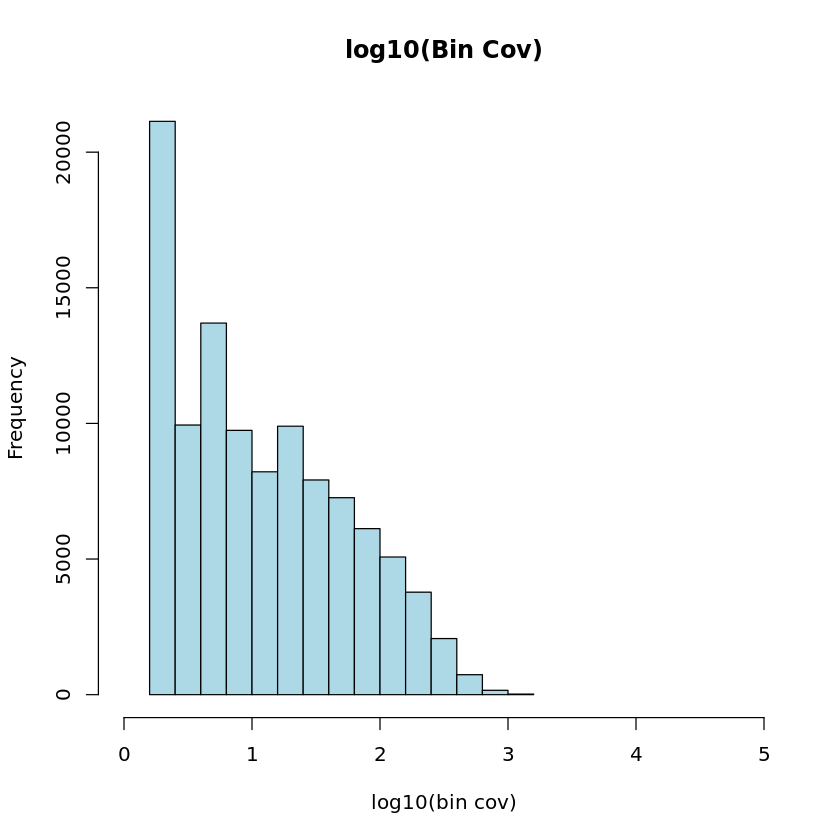

In [69]:
hist(   bin.cov[bin.cov > 0], 
        xlab="log10(bin cov)", 
        main="log10(Bin Cov)", 
        col="lightblue", 
        xlim=c(0, 5)
      );

In [ ]:
k4me1.sp <- runSnapATAC(k4me1.sp, metadata)

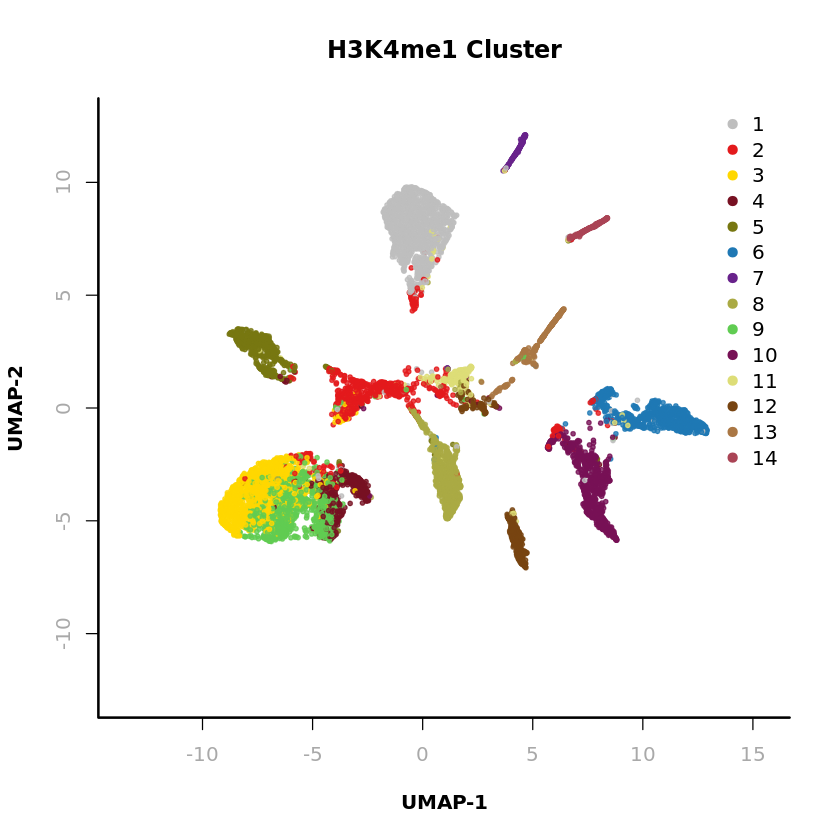

In [208]:
plotViz(
    obj=k4me1.sp,
    method="umap", 
    main="H3K4me1 Cluster",
    point.color=k4me1.sp@cluster, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='right'
  )

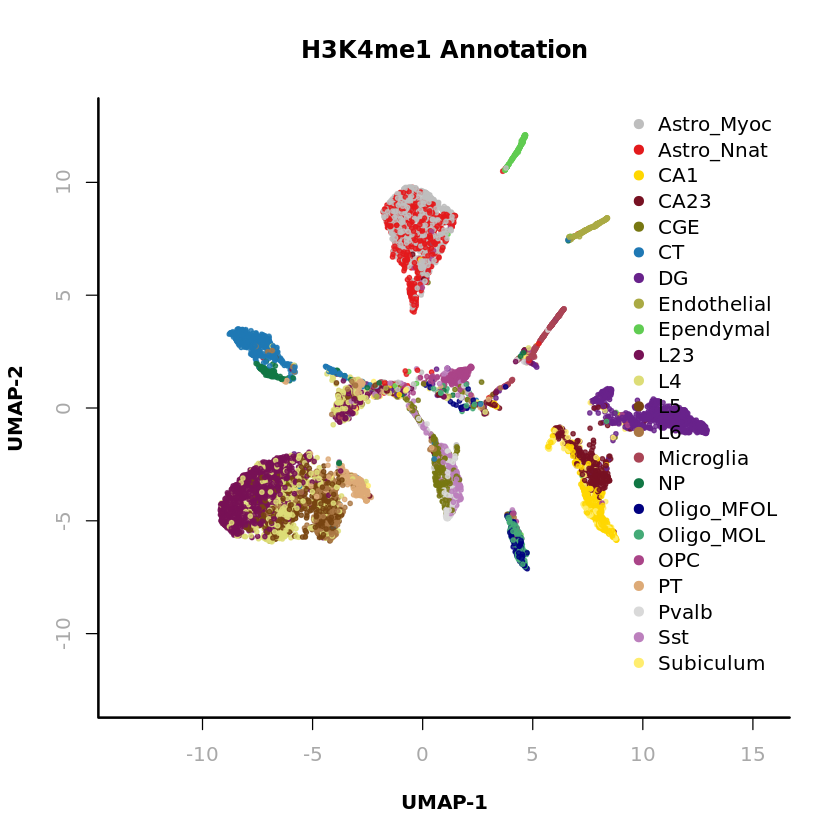

In [209]:
plotViz(
    obj=k4me1.sp,
    method="umap", 
    main="H3K4me1 Annotation",
    point.color=k4me1.sp@metaData$annotation, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='right',
  )

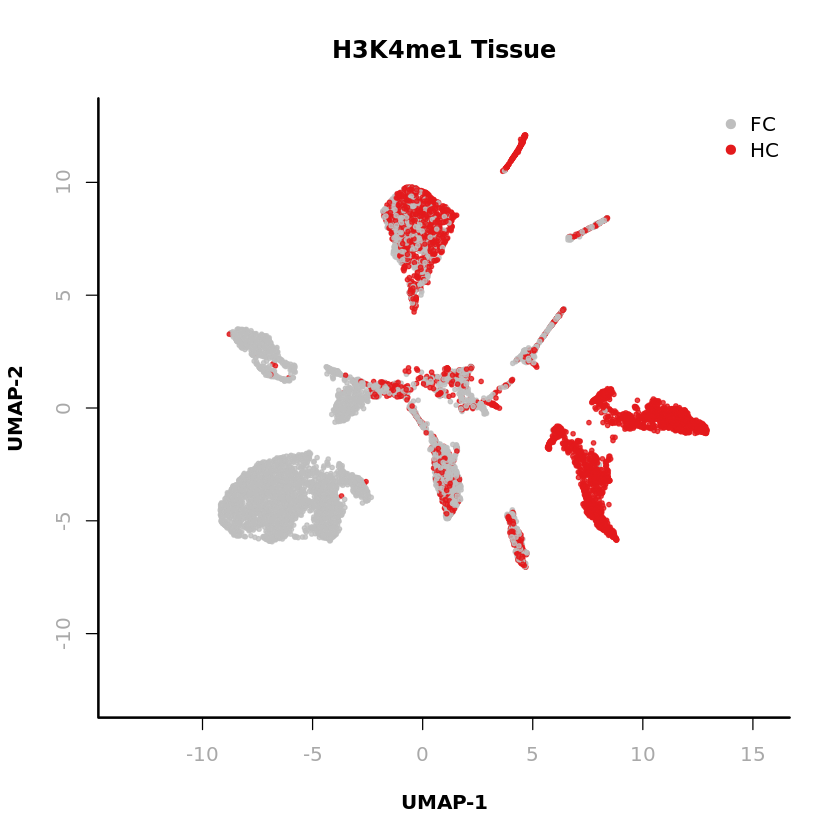

In [210]:
plotViz(
    obj=k4me1.sp,
    method="umap", 
    main="H3K4me1 Tissue",
    point.color=k4me1.sp@metaData$tissue, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='right'
  )

# imputed H3K4me1

In [29]:
mm = readMM('example/histone/SCRIPT/imputation/mtx_imputed_H3K4me1/matrix.mtx')
bc = read.csv('example/histone/SCRIPT/imputation/mtx_imputed_H3K4me1/barcodes.tsv', header = FALSE)$V1
bin = GRanges(read.csv('example/histone/SCRIPT/imputation/mtx_imputed_H3K4me1/bins.tsv', sep = '\t', header = FALSE)$V1)

In [40]:
k4me1.impute <- createSnapFromBmat(as.sparse(mm), barcodes = bc, bins = bin)

Epoch: checking the inputs ...

Epoch: computing jaccard similarity matrix ...

Epoch: fitting regression model ...

Epoch: performing normalization ...

Epoch: computing eigen decomposition ...

Epoch: Done



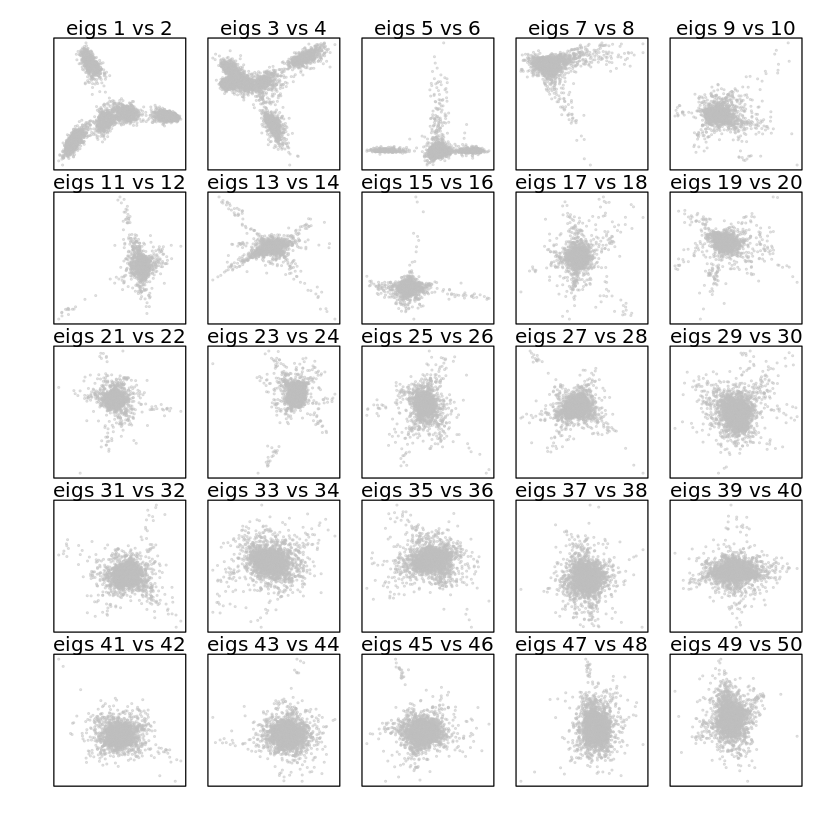

In [50]:
k4me1.impute <- runSnapATAC(k4me1.impute, metadata, binary = FALSE)

In [51]:
k4me1.impute

number of barcodes: 14095
number of bins: 100506
number of genes: 0
number of peaks: 0
number of motifs: 0

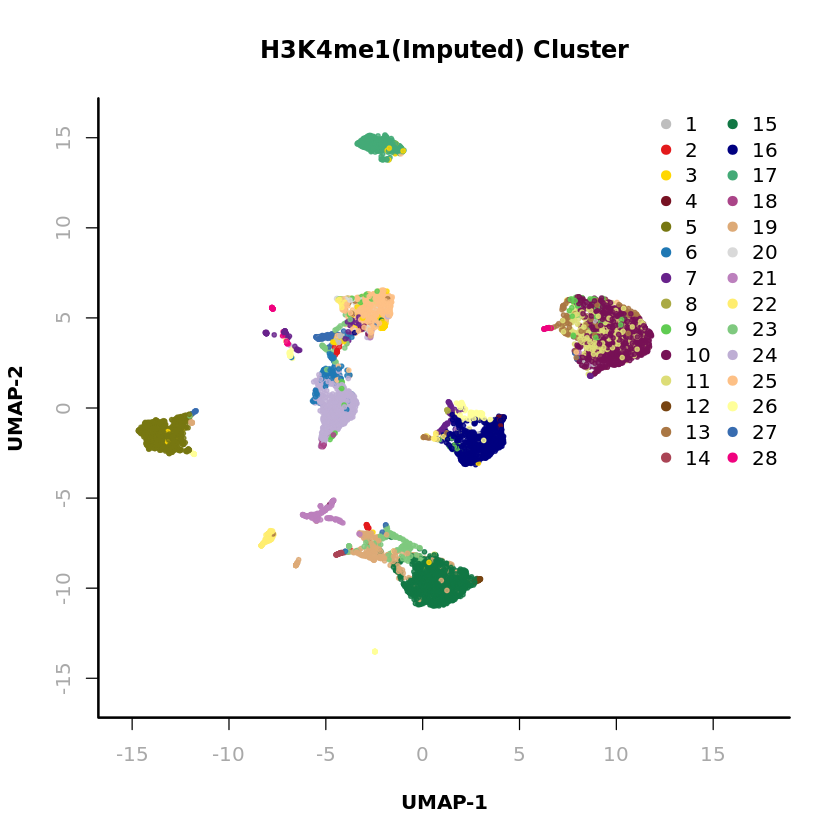

In [52]:
plotViz(
    obj=k4me1.impute,
    method="umap", 
    main="H3K4me1(Imputed) Cluster",
    point.color=k4me1.impute@cluster, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='right'
  )

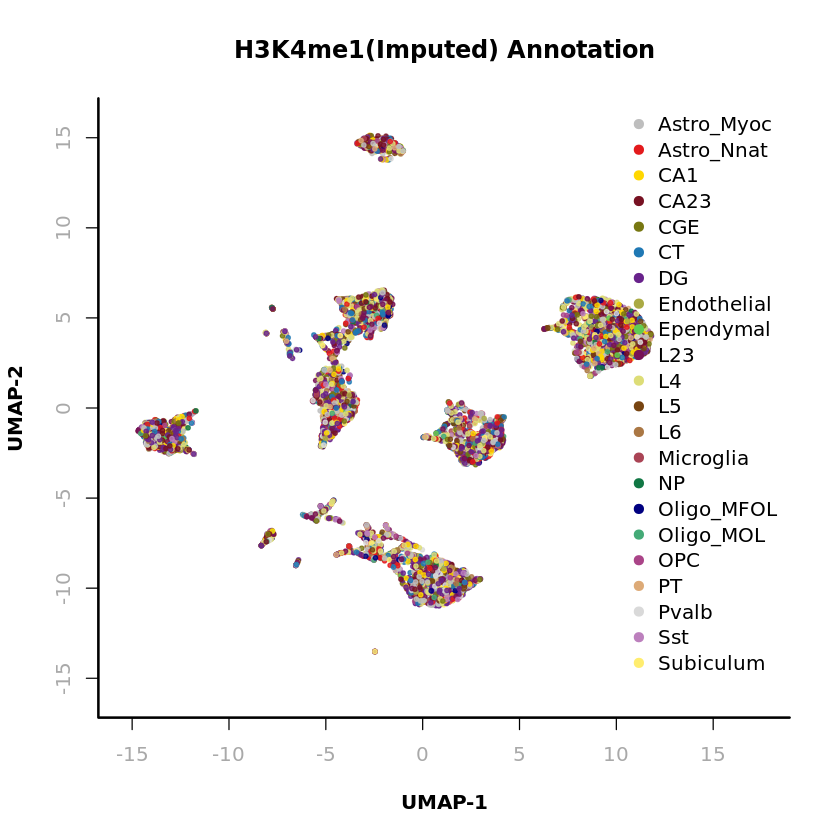

In [53]:
plotViz(
    obj=k4me1.impute,
    method="umap", 
    main="H3K4me1(Imputed) Annotation",
    point.color=k4me1.impute@metaData$annotation, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='right',
  )

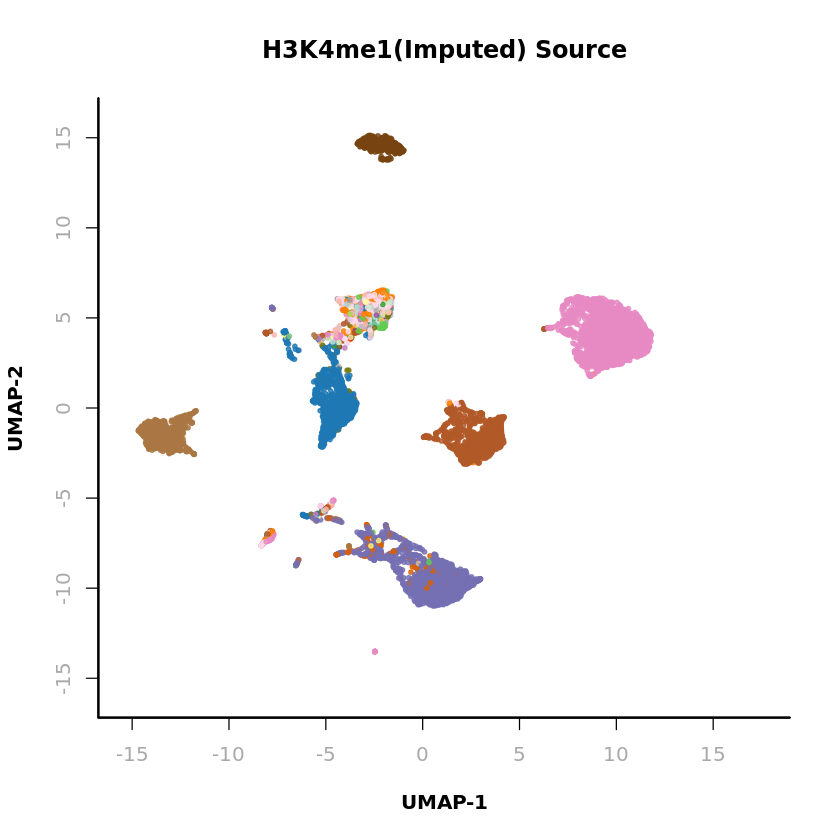

In [58]:
plotViz(
    obj=k4me1.impute,
    method="umap", 
    main="H3K4me1(Imputed) Source",
    point.color=k4me1.impute@metaData$H3K4me1, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='bottomleft',
  )

In [ ]:
?plotViz

# H3K4me3

In [211]:
mm = readMM('example/histone/data/matrix/03.Paired-Tag_H3K4me3_DNA_filtered_matrix/matrix.mtx')
bc = read.csv('example/histone/data/matrix/03.Paired-Tag_H3K4me3_DNA_filtered_matrix/barcodes.tsv', header = FALSE)$V1
bin = GRanges(read.csv('example/histone/data/matrix/03.Paired-Tag_H3K4me3_DNA_filtered_matrix/bins.tsv', sep = '\t', header = FALSE)$V1)

In [213]:
K4me3.sp <- createSnapFromBmat(t(as.sparse(mm)), barcodes = bc, bins = bin)

Epoch: checking the inputs ...

Epoch: computing jaccard similarity matrix ...

Epoch: fitting regression model ...

Epoch: performing normalization ...

Epoch: computing eigen decomposition ...

Epoch: Done



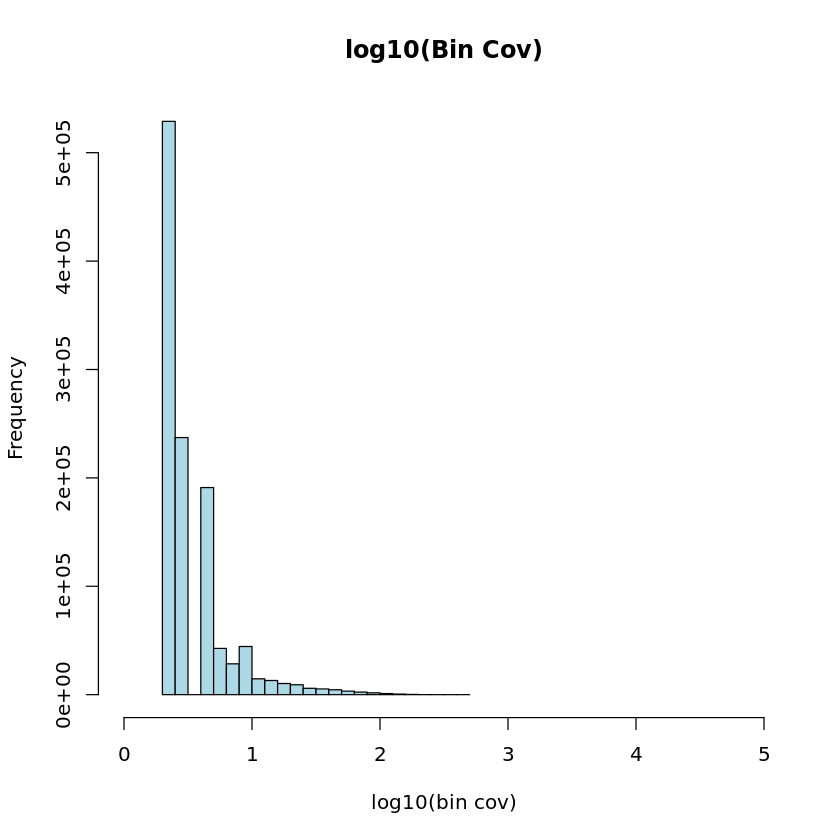

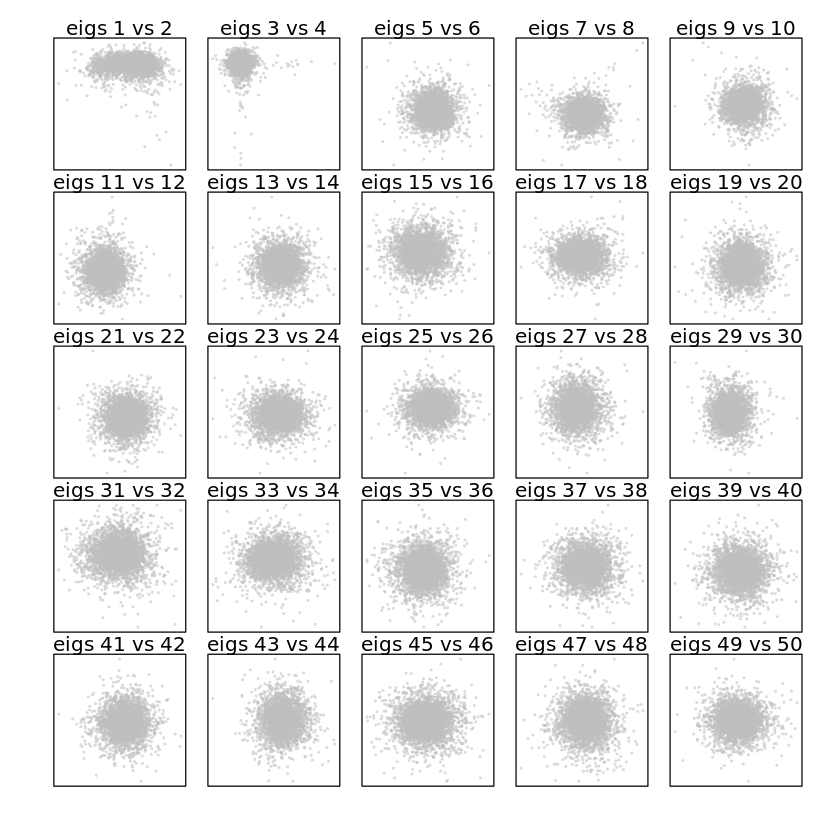

In [215]:
K4me3.sp <- process(K4me3.sp, metadata)

In [222]:
length(K4me3.sp@cluster)

[1] 7465

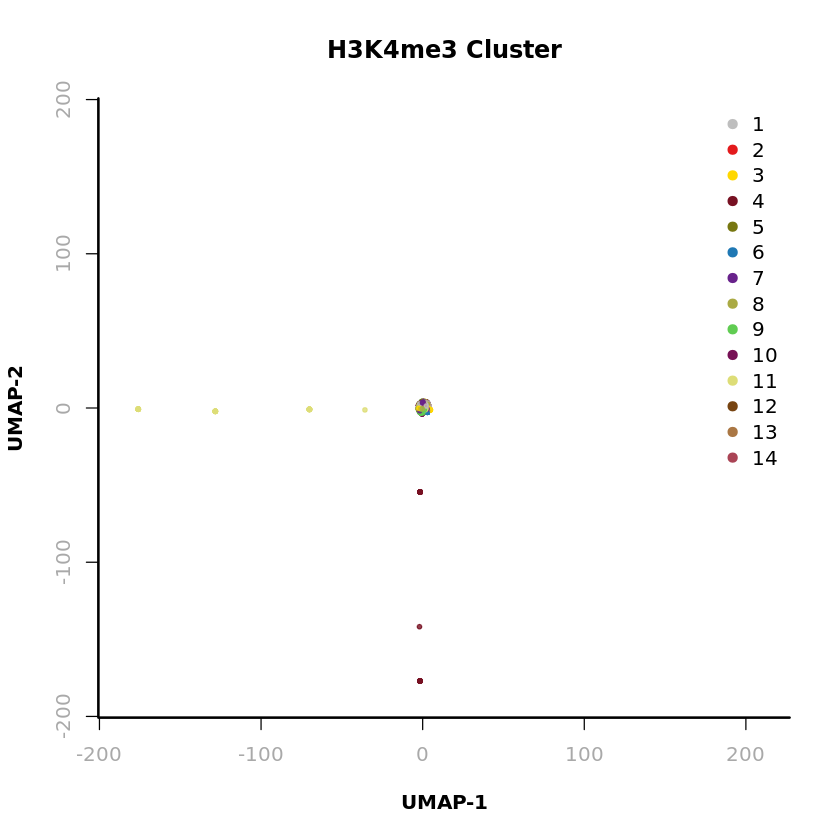

In [223]:
plotViz(
    obj=K4me3.sp,
    method="umap", 
    main="H3K4me3 Cluster",
    point.color=K4me3.sp@cluster, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='right'
  )

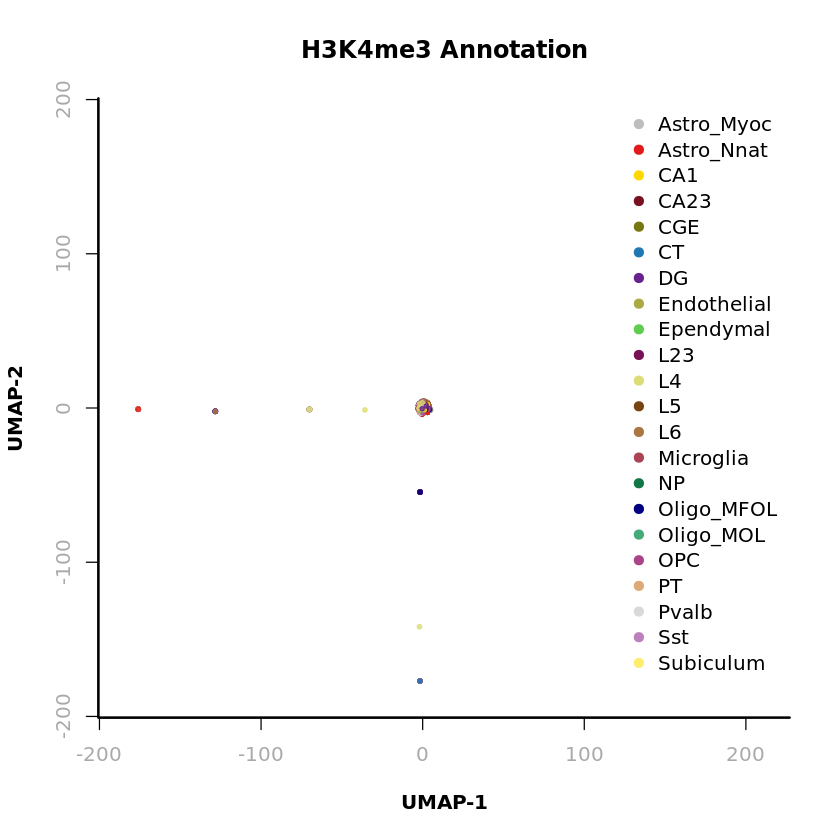

In [224]:
plotViz(
    obj=K4me3.sp,
    method="umap", 
    main="H3K4me3 Annotation",
    point.color=K4me3.sp@metaData$annotation, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='right',
  )

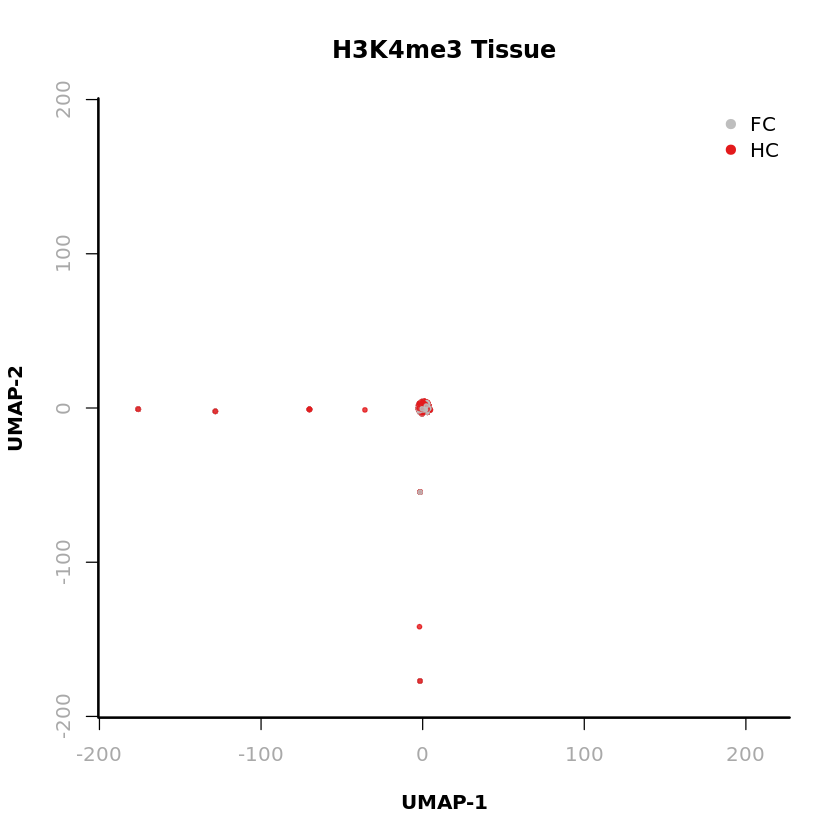

In [225]:
plotViz(
    obj=K4me3.sp,
    method="umap", 
    main="H3K4me3 Tissue",
    point.color=K4me3.sp@metaData$tissue, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='right'
  )

# ATAC

In [226]:
mm = readMM('example/histone/data/matrix/07.Paired-seq_DNA_filtered_matrix/matrix.mtx')
bc = read.csv('example/histone/data/matrix/07.Paired-seq_DNA_filtered_matrix/barcodes.tsv', header = FALSE)$V1
bin = GRanges(read.csv('example/histone/data/matrix/07.Paired-seq_DNA_filtered_matrix/bins.tsv', sep = '\t', header = FALSE)$V1)

In [227]:
atac.sp <- createSnapFromBmat(t(as.sparse(mm)), barcodes = bc, bins = bin)

Epoch: checking the inputs ...

Epoch: computing jaccard similarity matrix ...

Epoch: fitting regression model ...

Epoch: performing normalization ...

Epoch: computing eigen decomposition ...

Epoch: Done



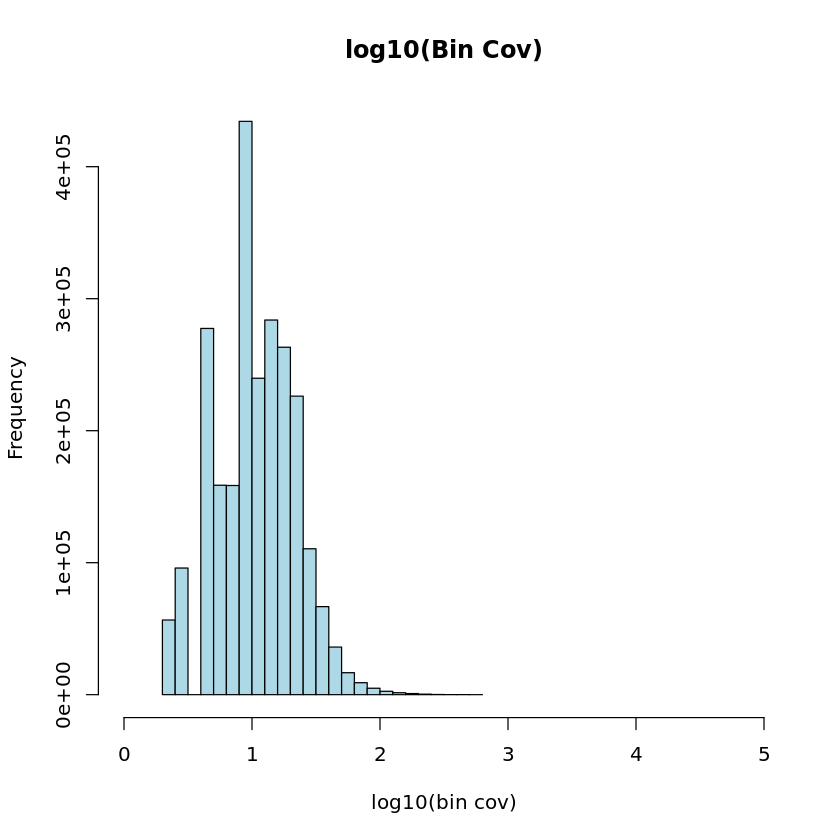

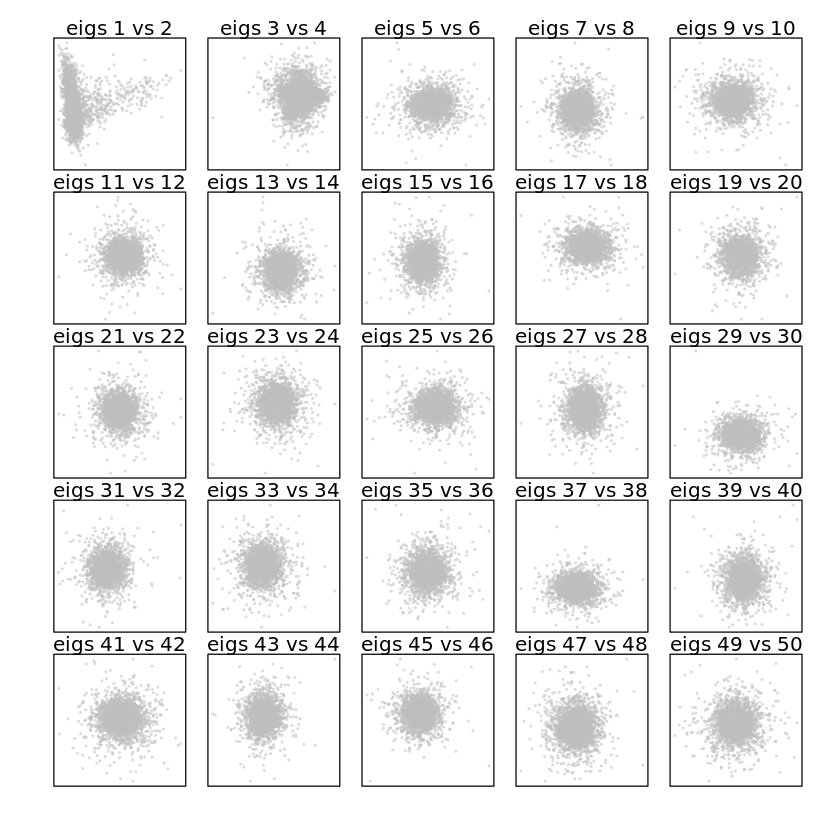

In [229]:
atac.sp <- process(atac.sp, metadata)

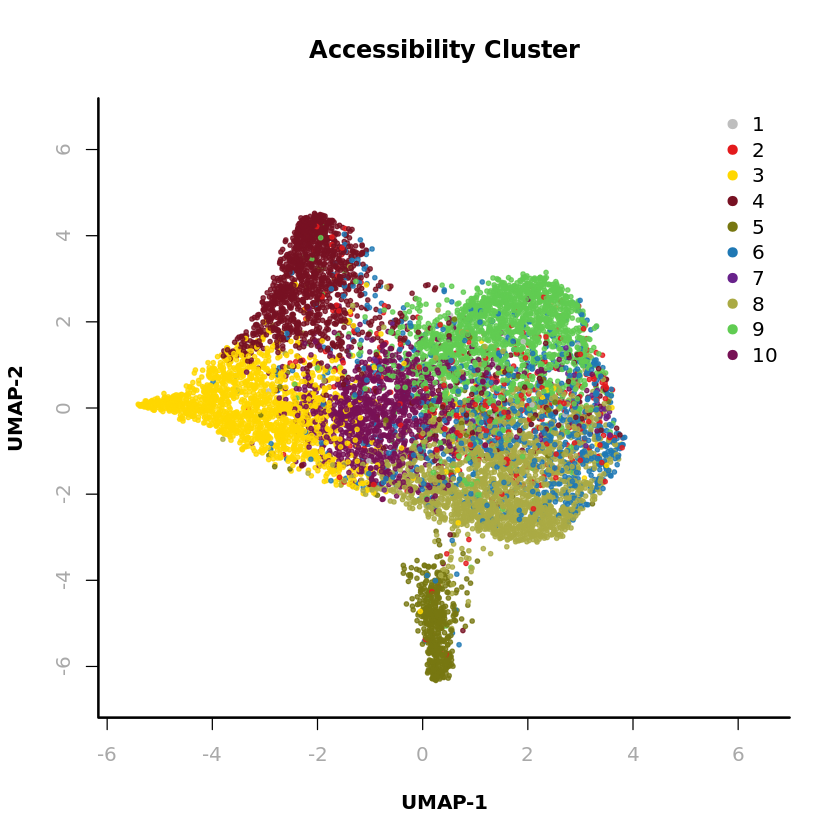

In [230]:
plotViz(
    obj=atac.sp,
    method="umap", 
    main="Accessibility Cluster",
    point.color=atac.sp@cluster, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='right'
  )

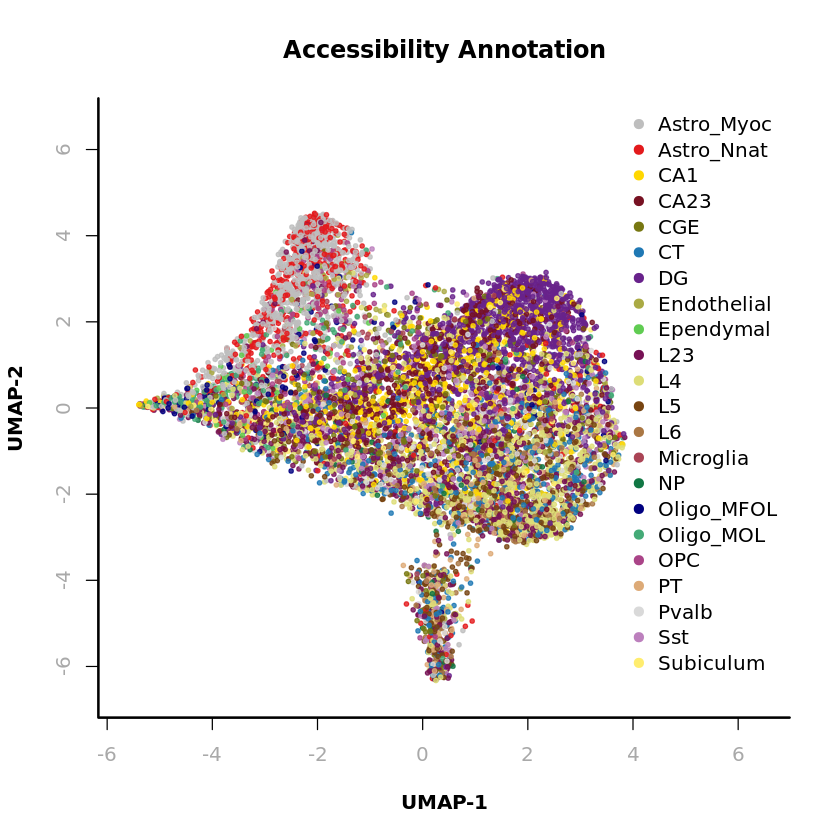

In [231]:
plotViz(
    obj=atac.sp,
    method="umap", 
    main="Accessibility Annotation",
    point.color=atac.sp@metaData$annotation, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='right',
  )

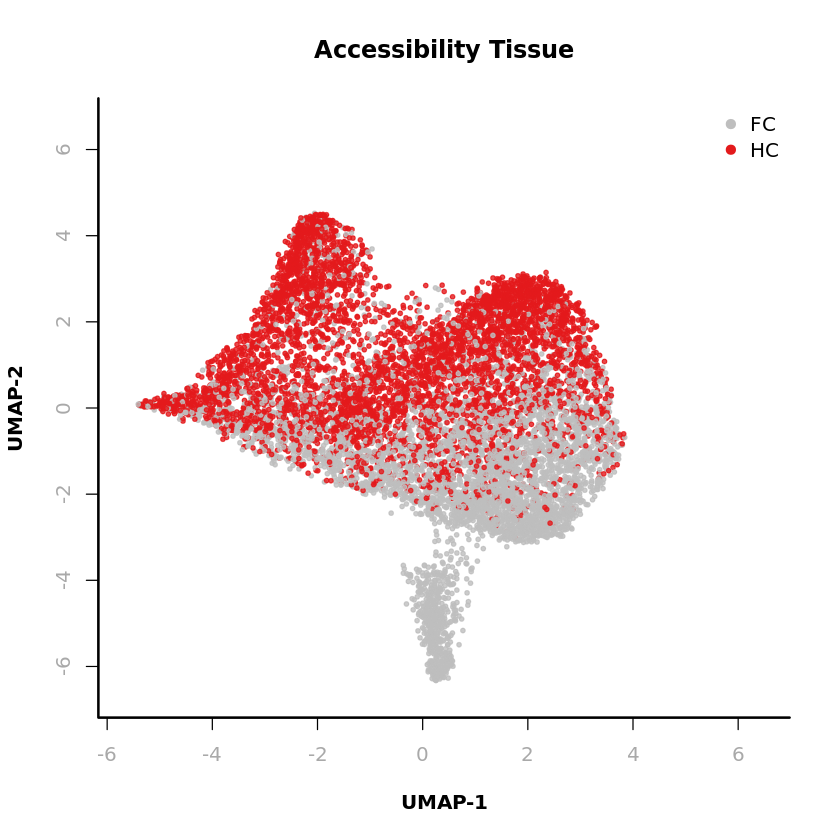

In [232]:
plotViz(
    obj=atac.sp,
    method="umap", 
    main="Accessibility Tissue",
    point.color=atac.sp@metaData$tissue, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='right'
  )